<div style="text-align:right">Justine Charrel - Master 2 Internship</div>
This script plot the monthly and seasonal southern ocean maps of low, mid, high and total cloud cover for CALIPSO-GOCCP, for LMDZ6A and for their difference.

### IMPORT

In [1]:
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

### READ DATA

In [3]:
# CALIPSO-GOCCP
path = '/home/jcharrel/Documents/M2_Internship_LMD/data/CALIPSO/'
ncfile_obs=path+"CALIPSO_2DCloudCover_seasonal_2008-2022_CFMIP2_sat_3.1.4_r144x90.nc"
nc_obs = netCDF4.Dataset(ncfile_obs)

In [4]:
# MASK
path = '/home/jcharrel/Documents/M2_Internship_LMD/data/LMDZ6A/'
ncfile_mask=path+"LmdzOr6Actrl_SE_1980_1999_1M_histmth_phis_r144x90.nc"
nc_mask = netCDF4.Dataset(ncfile_mask)

In [5]:
# LMDZ6A
path = '/home/jcharrel/Documents/M2_Internship_LMD/data/LMDZ6A/'
ncfile_lmdz6a=path+'LmdzOr6Actrl_calipso_r144x90.nc'
nc_lmdz6a = netCDF4.Dataset(ncfile_lmdz6a)

In [7]:
# GRID
lon = nc_obs.variables['lon'][:]
lat = nc_obs.variables['lat'][:]

lat_id = lat <= -30
lat = lat[lat <= -30]

# Circle plot for polar projection
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

### LOAD VARIABLES

In [8]:
# CALIPSO-GOCCP
clcobs = nc_obs.variables['clccalipso'][:,lat_id,:]
clcobs = np.ma.dstack((clcobs))
cllobs = nc_obs.variables['cllcalipso'][:,lat_id,:]
cllobs = np.ma.dstack((cllobs))
clmobs = nc_obs.variables['clmcalipso'][:,lat_id,:]
clmobs = np.ma.dstack((clmobs))
clhobs = nc_obs.variables['clhcalipso'][:,lat_id,:]
clhobs = np.ma.dstack((clhobs))
cltobs = nc_obs.variables['cltcalipso'][:,lat_id,:]
cltobs = np.ma.dstack((cltobs))

# LMDZ6A
clllmdz6a = nc_lmdz6a.variables['cllcalipso'][:,lat_id,:]
clllmdz6a[clllmdz6a>1e5] = np.nan
clmlmdz6a = nc_lmdz6a.variables['clmcalipso'][:,lat_id,:]
clmlmdz6a[clmlmdz6a>1e5] = np.nan
clhlmdz6a = nc_lmdz6a.variables['clhcalipso'][:,lat_id,:]
clhlmdz6a[clhlmdz6a>1e5] = np.nan
cltlmdz6a = nc_lmdz6a.variables['cltcalipso'][:,lat_id,:]
cltlmdz6a[cltlmdz6a>1e5] = np.nan

# DIFFERENCE
clldiff = np.ma.dstack((clllmdz6a))-cllobs
clmdiff = np.ma.dstack((clmlmdz6a))-clmobs
clhdiff = np.ma.dstack((clhlmdz6a))-clhobs
cltdiff = np.ma.dstack((cltlmdz6a))-cltobs

clllmdz6a = np.dstack((clllmdz6a))
clmlmdz6a = np.dstack((clmlmdz6a))
clhlmdz6a = np.dstack((clhlmdz6a))
cltlmdz6a = np.dstack((cltlmdz6a))

# GEOPOTENTIAL
g = 9.81 # m/s
alt = nc_mask.variables['phis'][:,lat_id,:]/g #m

In [9]:
# MASK
mask_antarctica = np.where(alt > 0.1, 1, np.nan) #pour masquer la partie antarctique
mask_antarctica = np.dstack((mask_antarctica))

In [10]:
# MASK CALIPSO-GOCCP
clcobs = np.ma.masked_where(mask_antarctica >=0, clcobs)
cllobs = np.ma.masked_where(mask_antarctica >=0, cllobs)
clmobs = np.ma.masked_where(mask_antarctica >=0, clmobs)
clhobs = np.ma.masked_where(mask_antarctica >=0, clhobs)
cltobs = np.ma.masked_where(mask_antarctica >=0, cltobs)

# MASK LMDZ6A
clllmdz6a = np.ma.masked_where(mask_antarctica >=0, clllmdz6a)
clmlmdz6a = np.ma.masked_where(mask_antarctica >=0, clmlmdz6a)
clhlmdz6a = np.ma.masked_where(mask_antarctica >=0, clhlmdz6a)
cltlmdz6a = np.ma.masked_where(mask_antarctica >=0, cltlmdz6a)

# MASK DIFFERENCE
clldiff = np.ma.masked_where(mask_antarctica >=0, clldiff)
clmdiff = np.ma.masked_where(mask_antarctica >=0, clmdiff)
clhdiff = np.ma.masked_where(mask_antarctica >=0, clhdiff)
cltdiff = np.ma.masked_where(mask_antarctica >=0, cltdiff)

### MONTHLY MAPS

In [11]:
# FUNCTION
def plot_monthly_maps(var, clevs, cmap, norm, title, save) :
    fig, axes = plt.subplots(figsize=(16,9), nrows=3, ncols=4, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
    
    title_list = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Jun', 'Jui', 'Aou', 'Sep', 'Oct', 'Nov', 'Dec']
    pltcounter = 0
    for plotid in axes.flat:
        
        pltcounter = pltcounter + 1
        
        clplot = var[:,:,pltcounter-1]
        
        clplt, lonplt = add_cyclic_point(clplot, coord=lon) # filling the gap at longitude 0
    
        plotid.set_extent([-180, 180, np.min(lat), np.max(lat)], ccrs.PlateCarree())
        plotid.set_boundary(map_circle, transform=plotid.transAxes)
        
        cs = plotid.contourf(lonplt, lat, clplt, clevs, transform=ccrs.PlateCarree(),  
                             norm = norm, 
                             cmap=cmap)
        
        plotid.coastlines(resolution="110m",linewidth=1)
        plotid.set_title(title_list[pltcounter-1])
        
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(right=0.88, wspace=0.1)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.008, 0.7])
    fig.colorbar(cs, cax=cbar_ax, ticks=clevs, label='Cloud cover')
    path_fig = '/home/jcharrel/Documents/M2_Internship_LMD/figures/2DCloudCover/maps/monthly/'
    plt.savefig(path_fig+save,dpi=300)

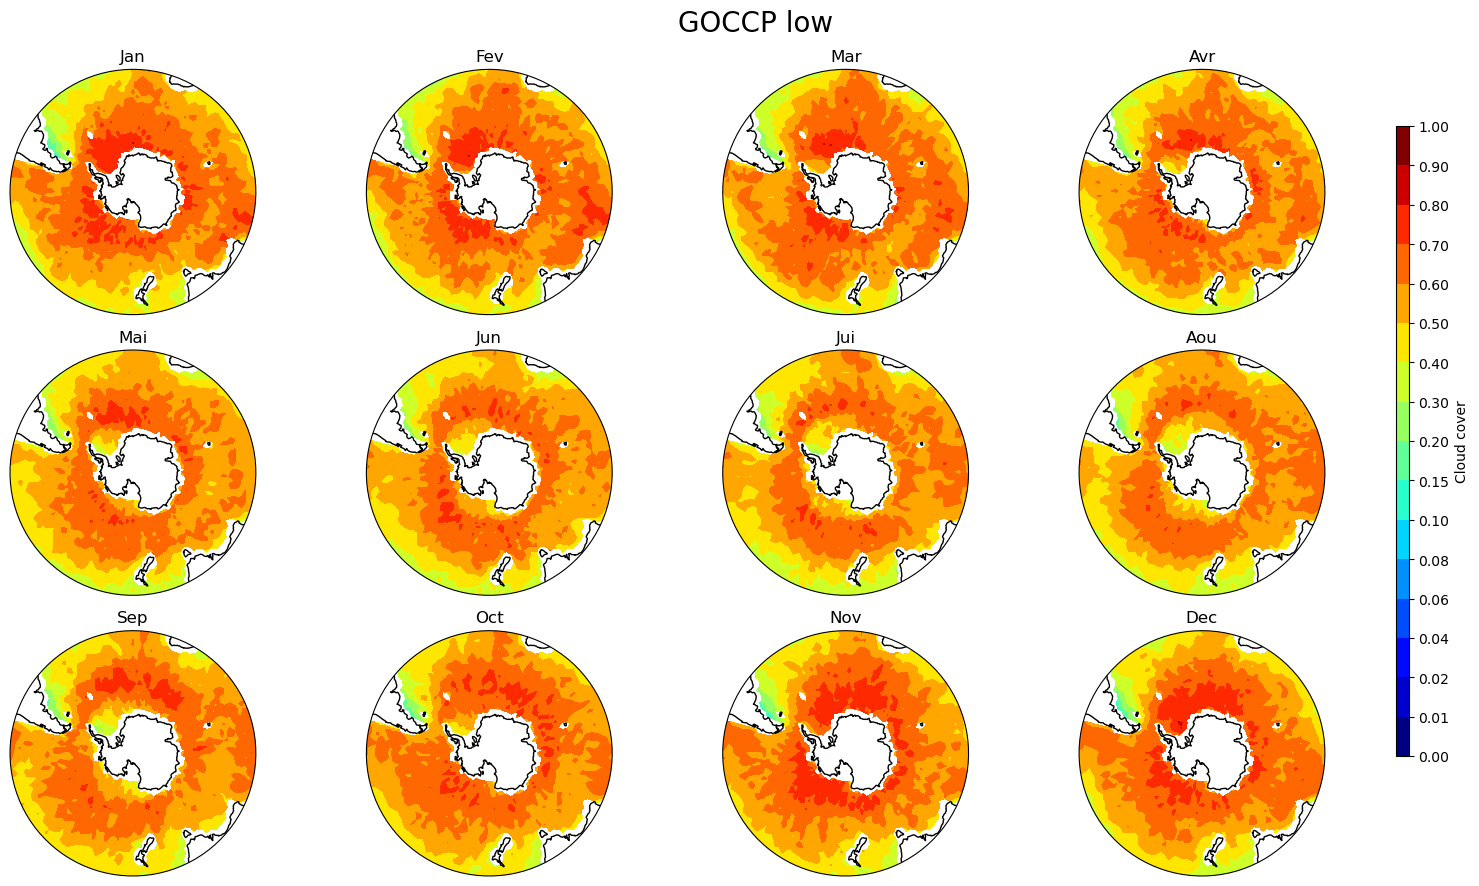

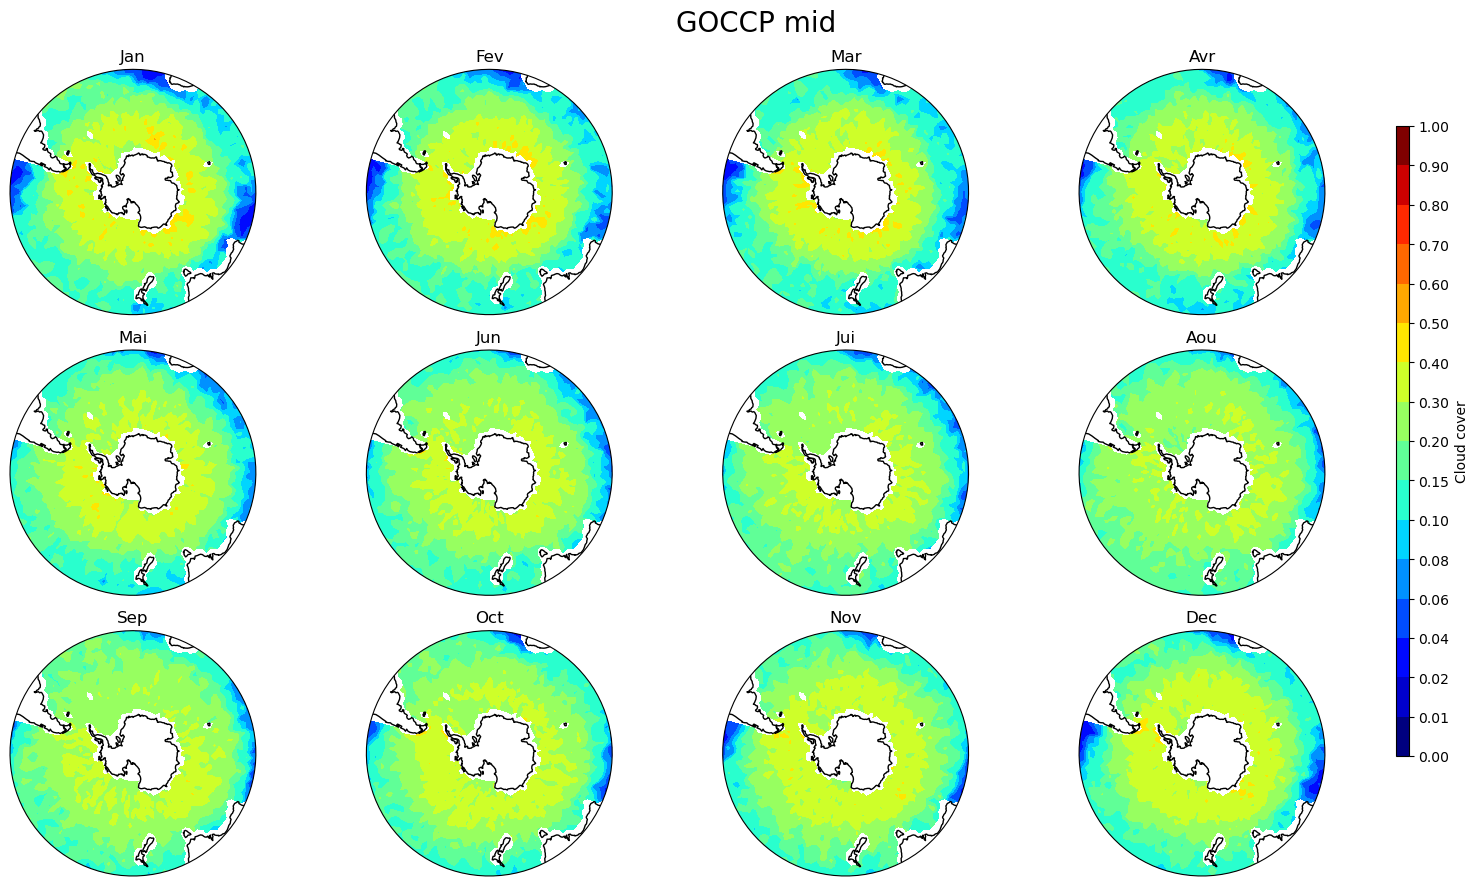

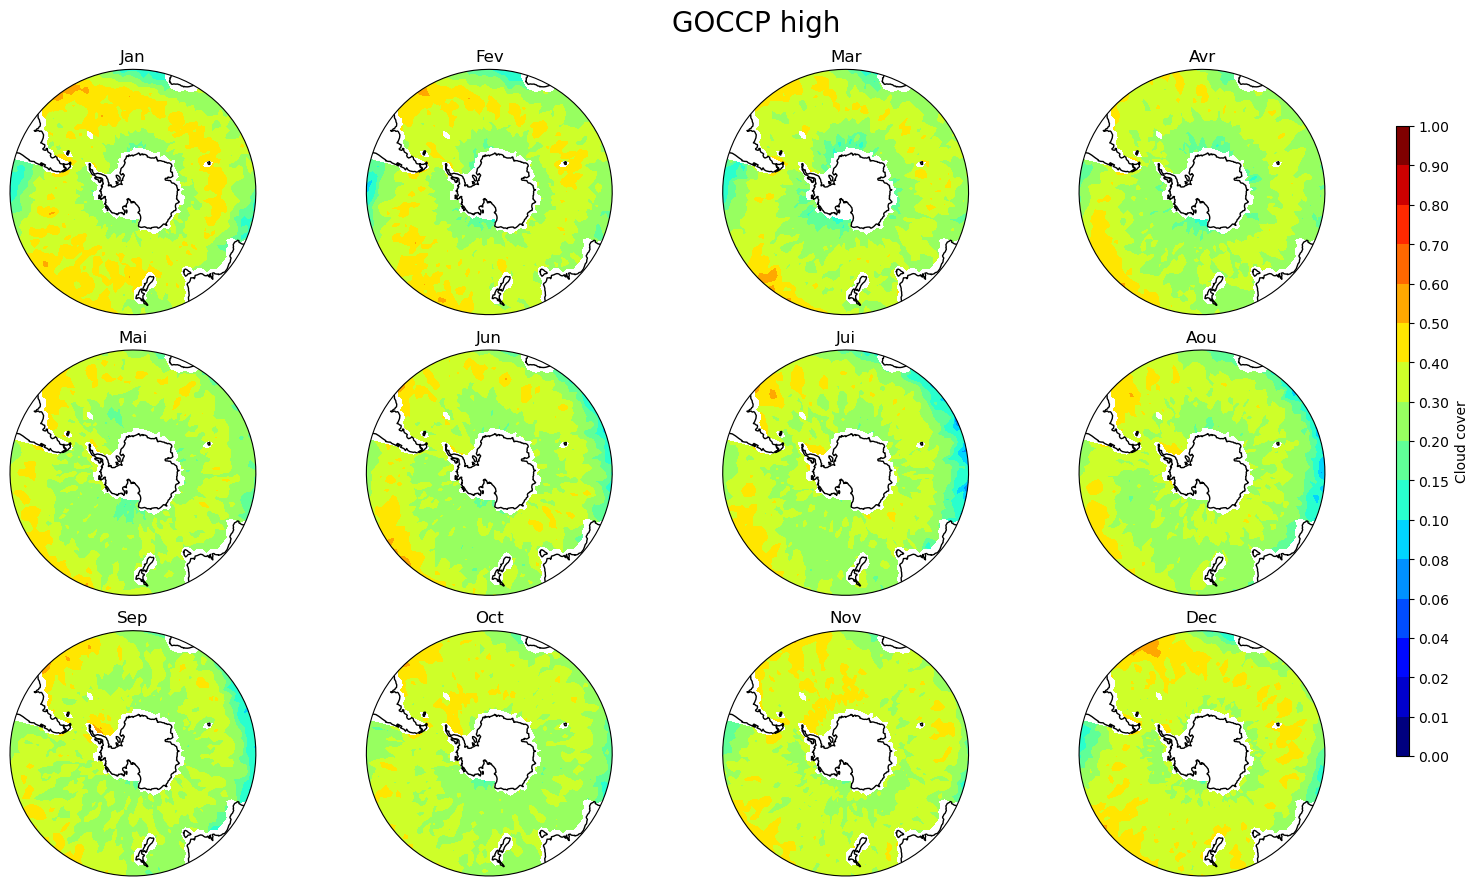

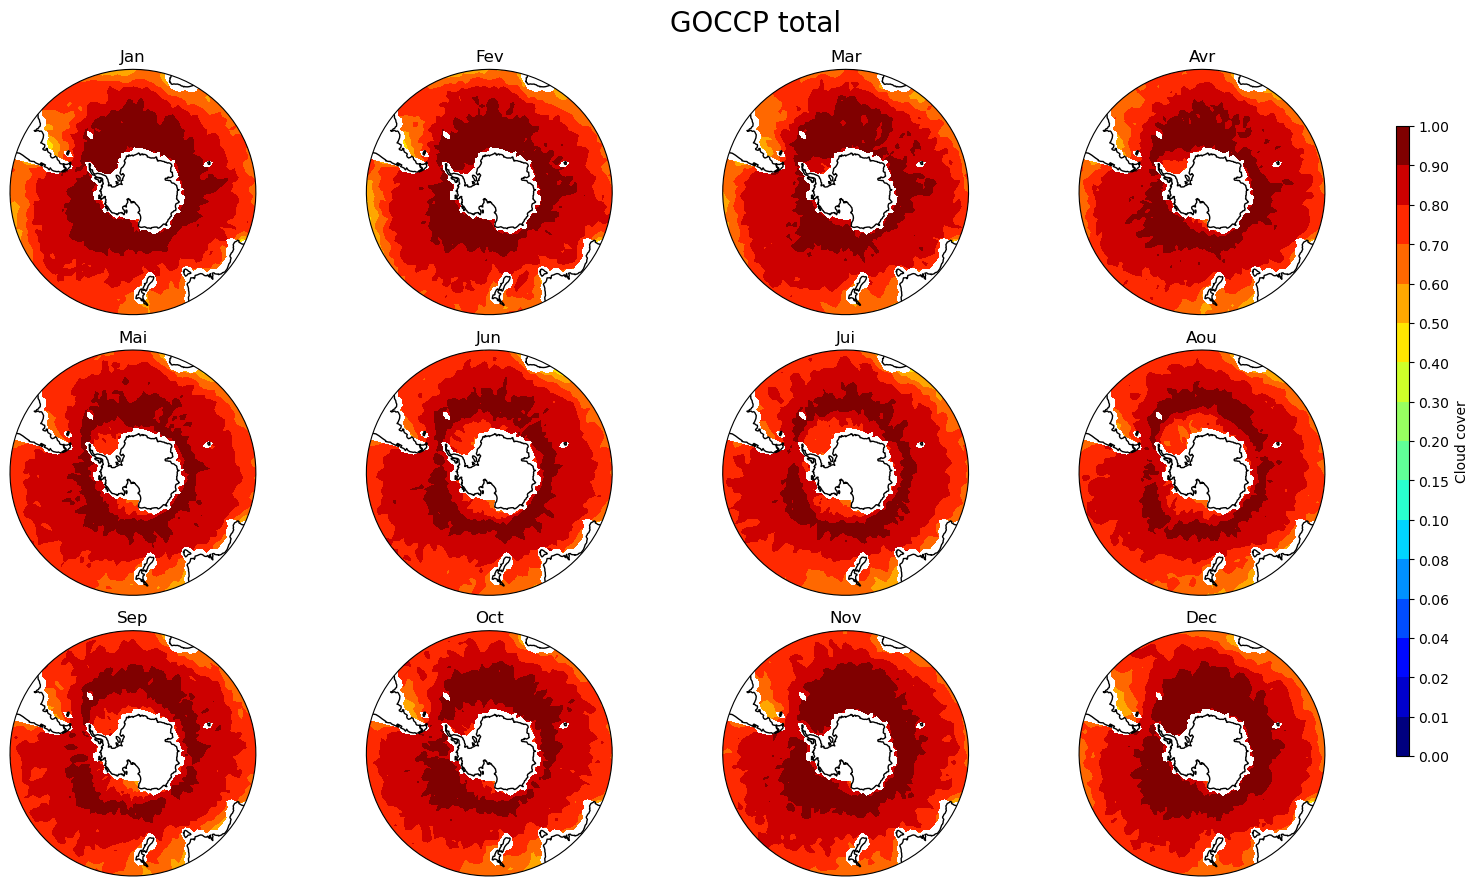

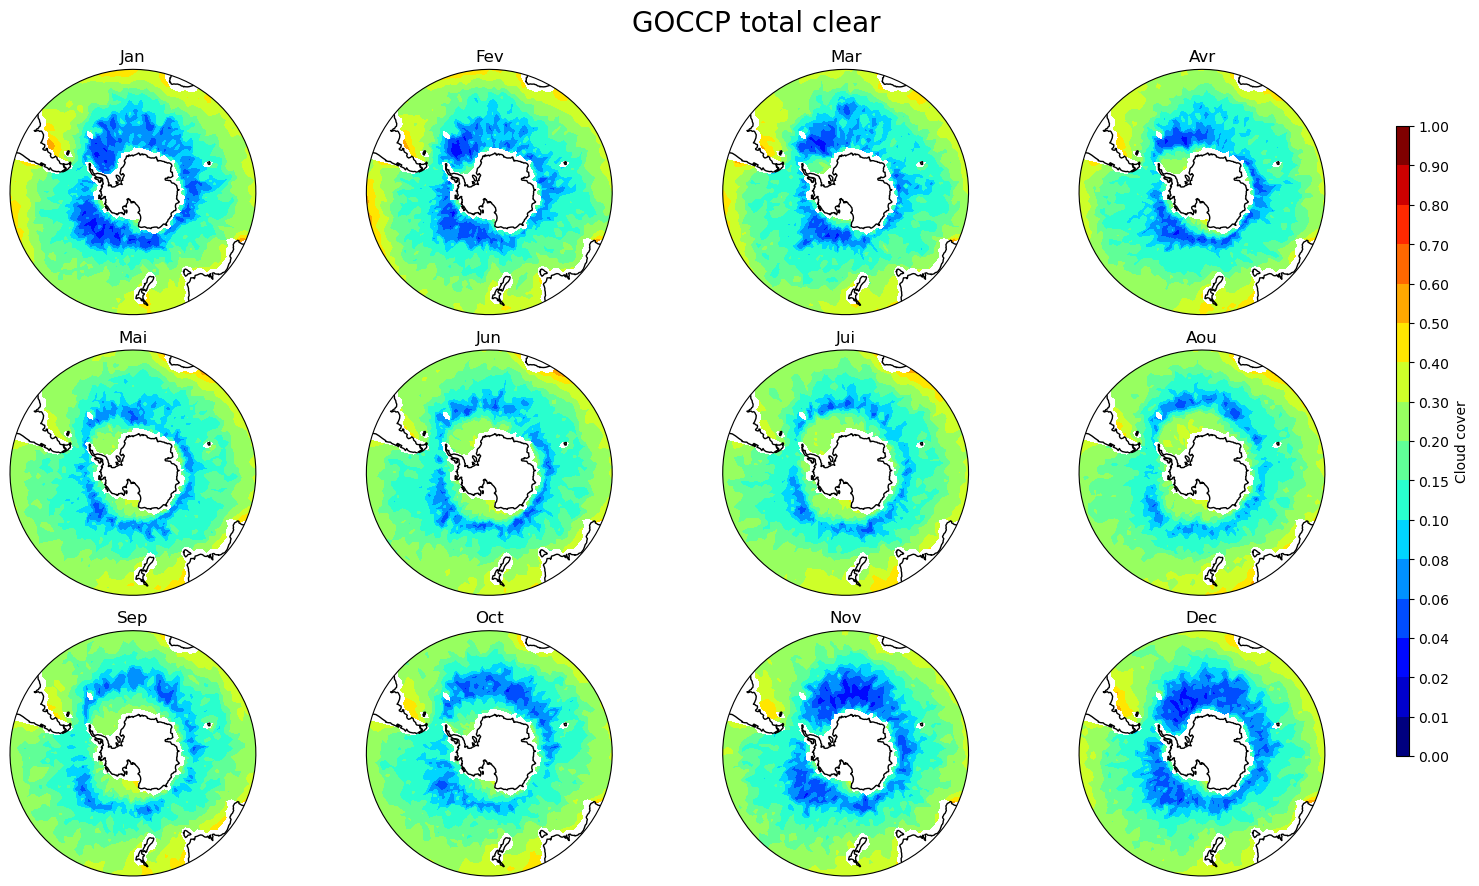

In [12]:
clevs = np.array([0,1,2,4,6,8,10,15,20,30,40,50,60,70,80,90,100])*1e-2
cmap = 'jet'
norm = mpl.colors.BoundaryNorm(boundaries=clevs, ncolors=256)
plot_monthly_maps(cllobs, clevs, cmap, norm, title='GOCCP low', save='cll_monthly_austral_obs.png')
plot_monthly_maps(clmobs, clevs, cmap, norm, title='GOCCP mid', save='clm_monthly_austral_obs.png')
plot_monthly_maps(clhobs, clevs, cmap, norm, title='GOCCP high', save='clh_monthly_austral_obs.png')
plot_monthly_maps(cltobs, clevs, cmap, norm, title='GOCCP total', save='clt_monthly_austral_obs.png')
plot_monthly_maps(clcobs, clevs, cmap, norm, title='GOCCP total clear', save='clc_monthly_austral_obs.png')

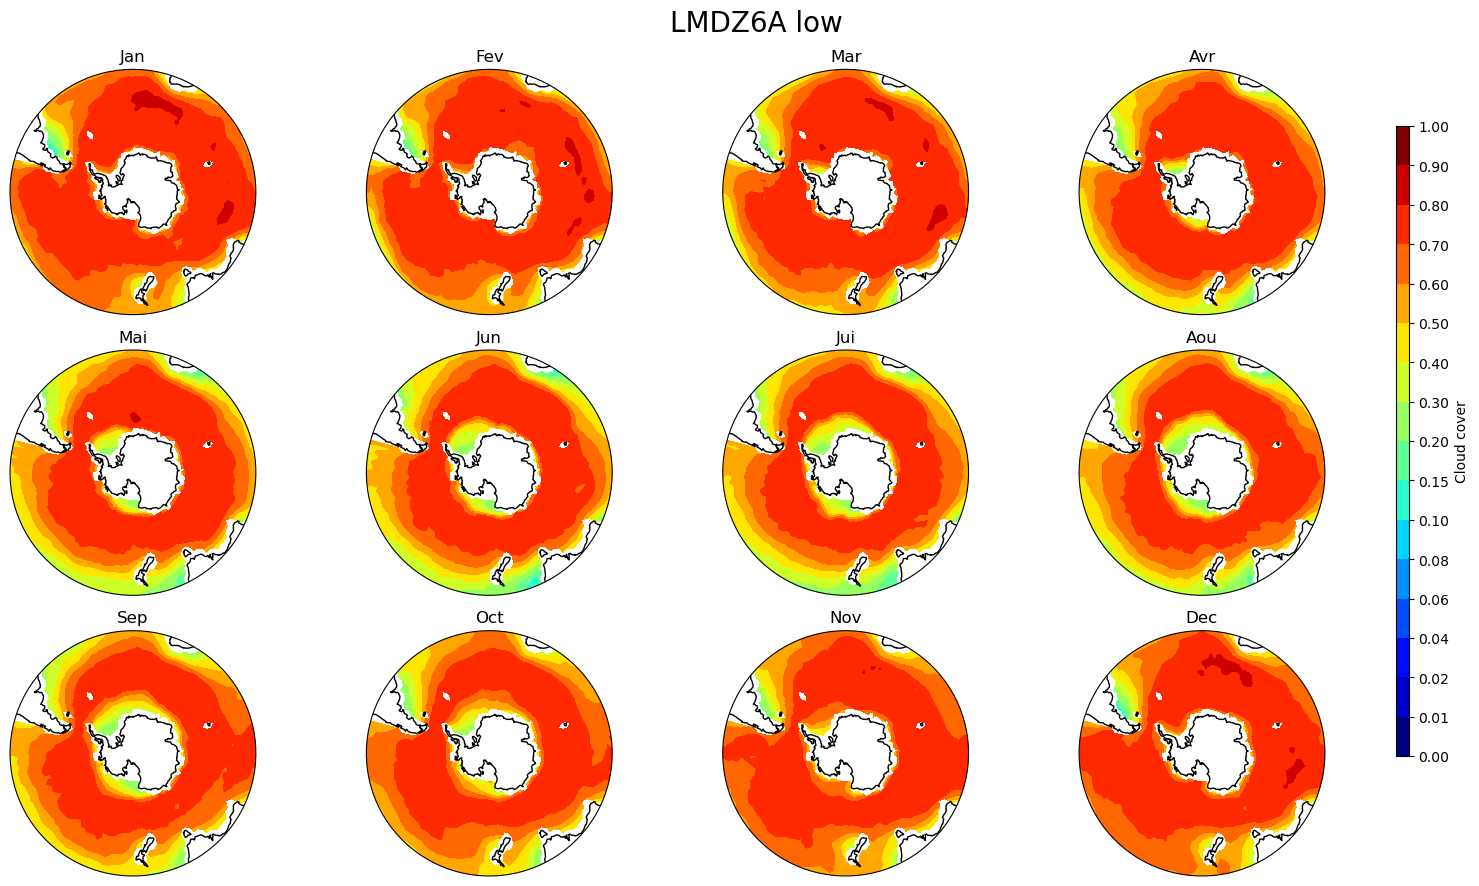

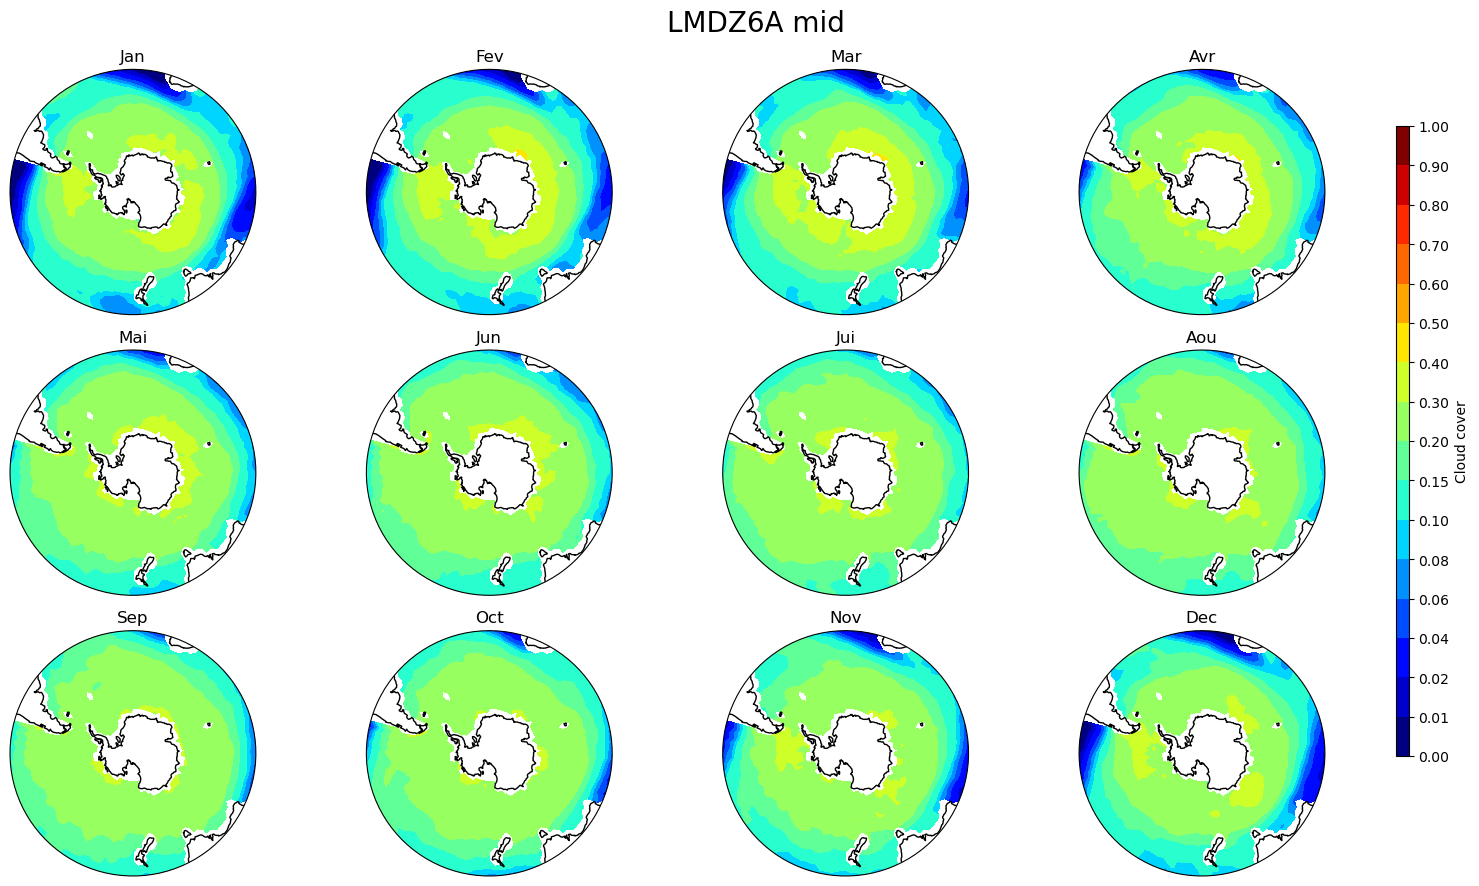

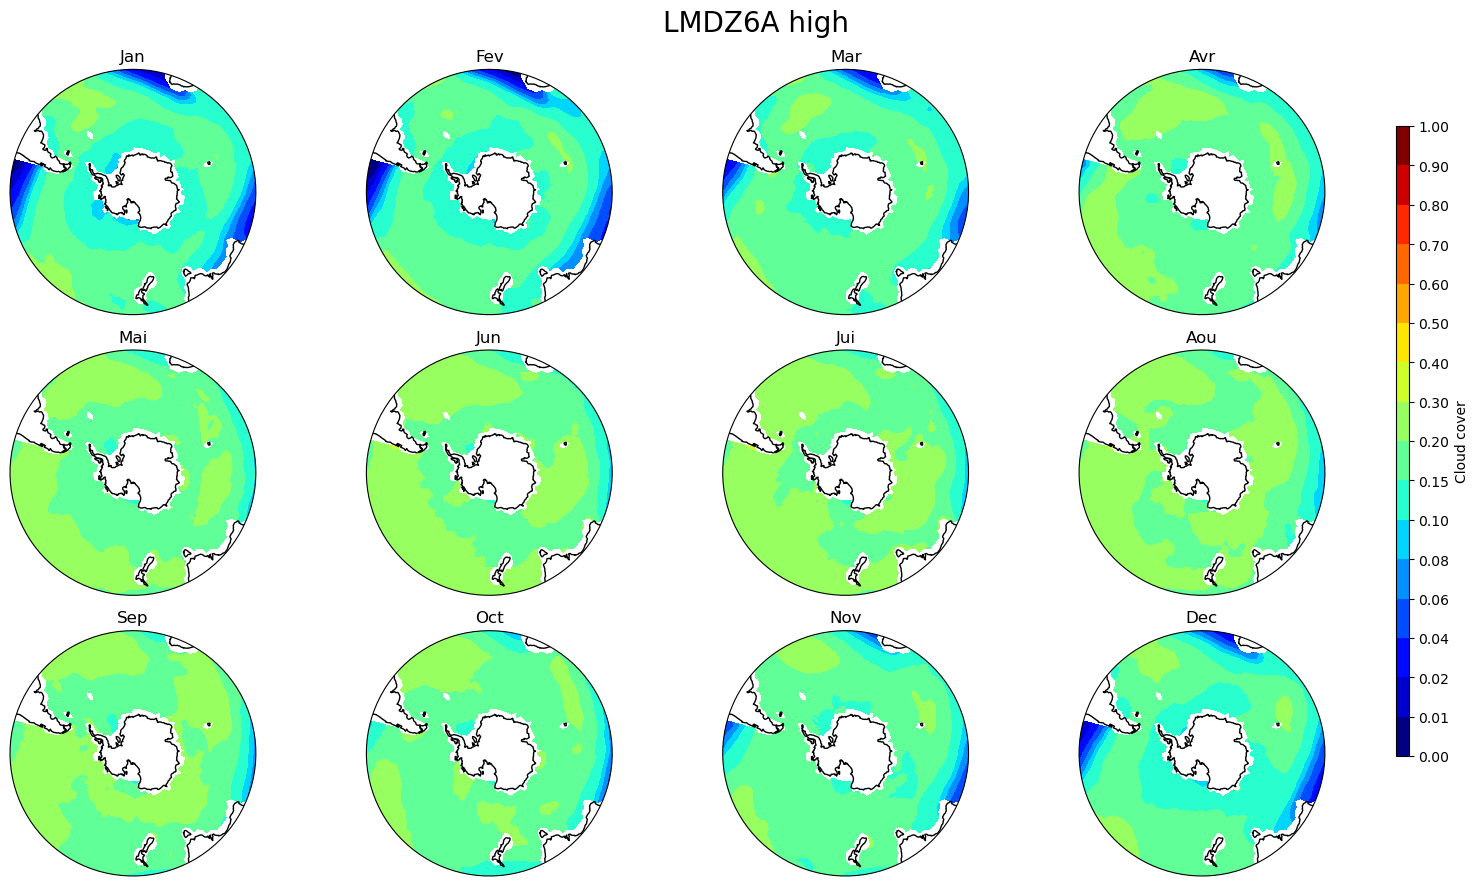

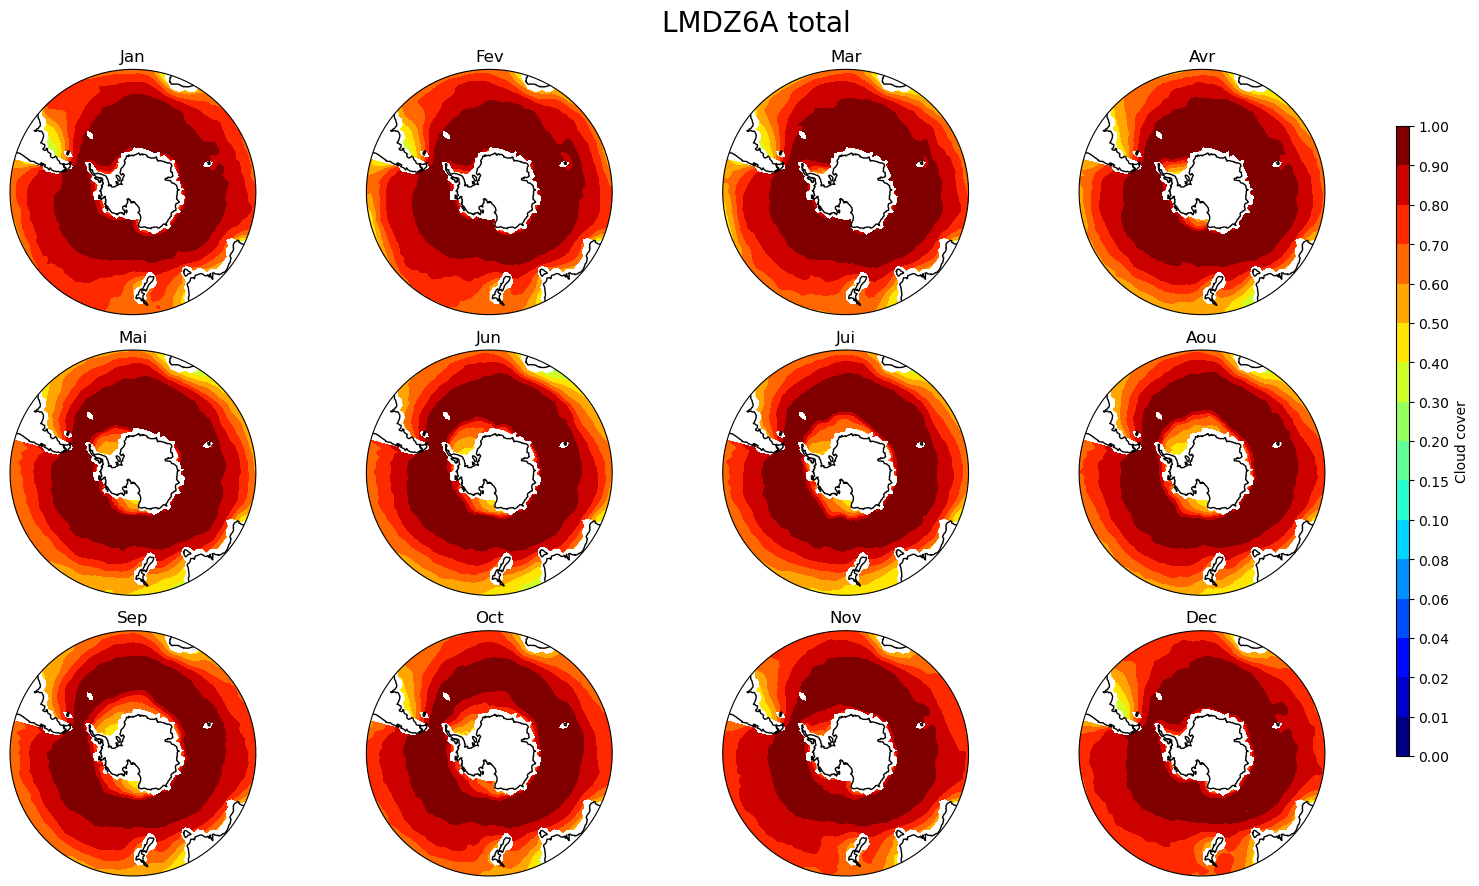

In [13]:
plot_monthly_maps(clllmdz6a, clevs, cmap, norm, title='LMDZ6A low', save='cll_monthly_austral_lmdz6a.png')
plot_monthly_maps(clmlmdz6a, clevs, cmap, norm, title='LMDZ6A mid', save='clm_monthly_austral_lmdz6a.png')
plot_monthly_maps(clhlmdz6a, clevs, cmap, norm, title='LMDZ6A high', save='clh_monthly_austral_lmdz6a.png')
plot_monthly_maps(cltlmdz6a, clevs, cmap, norm, title='LMDZ6A total', save='clt_monthly_austral_lmdz6a.png')

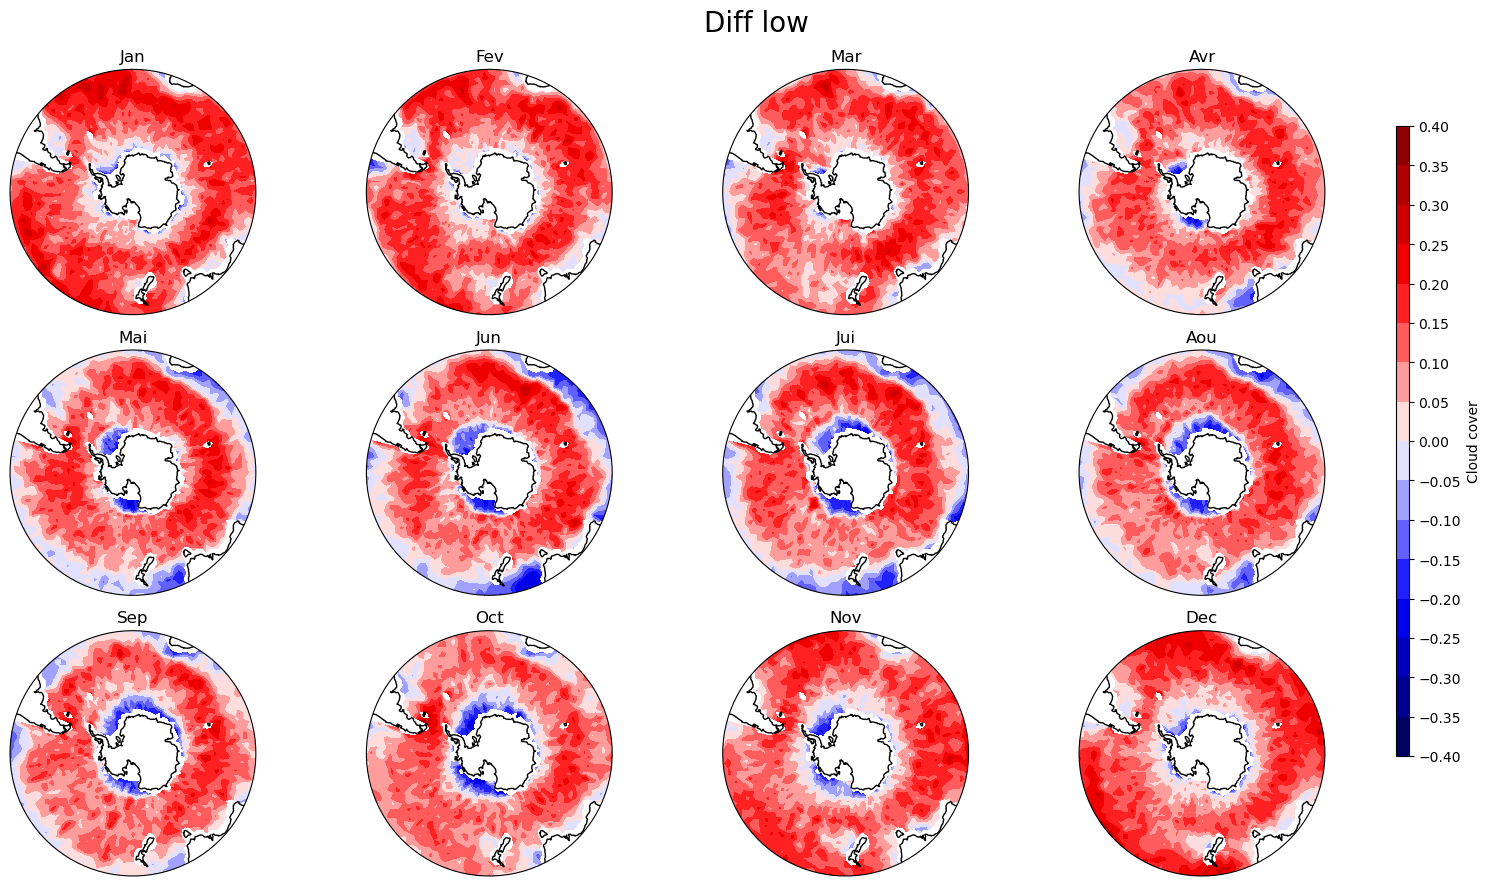

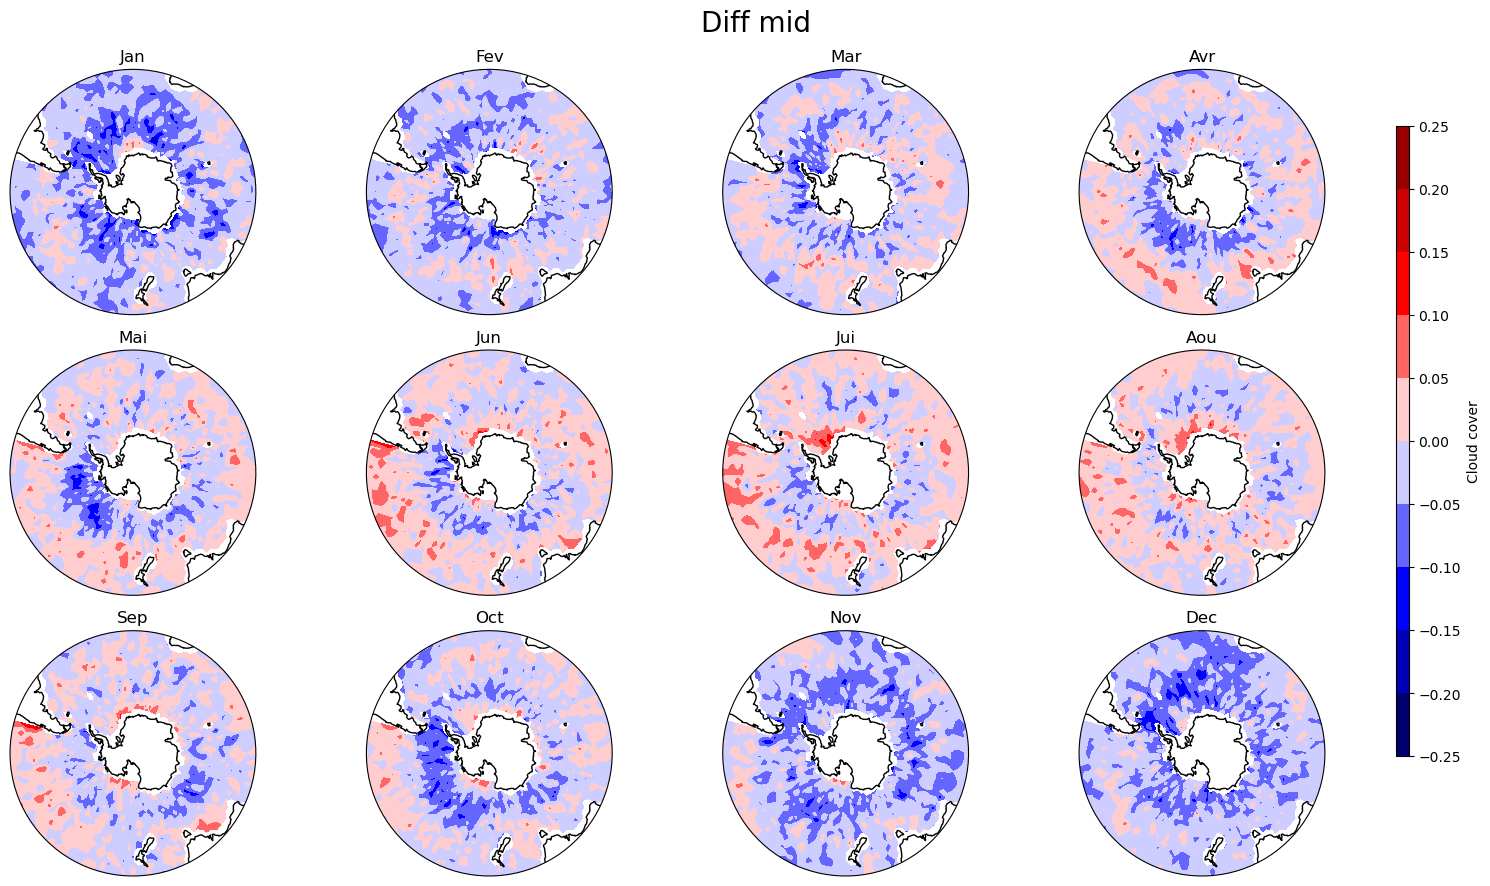

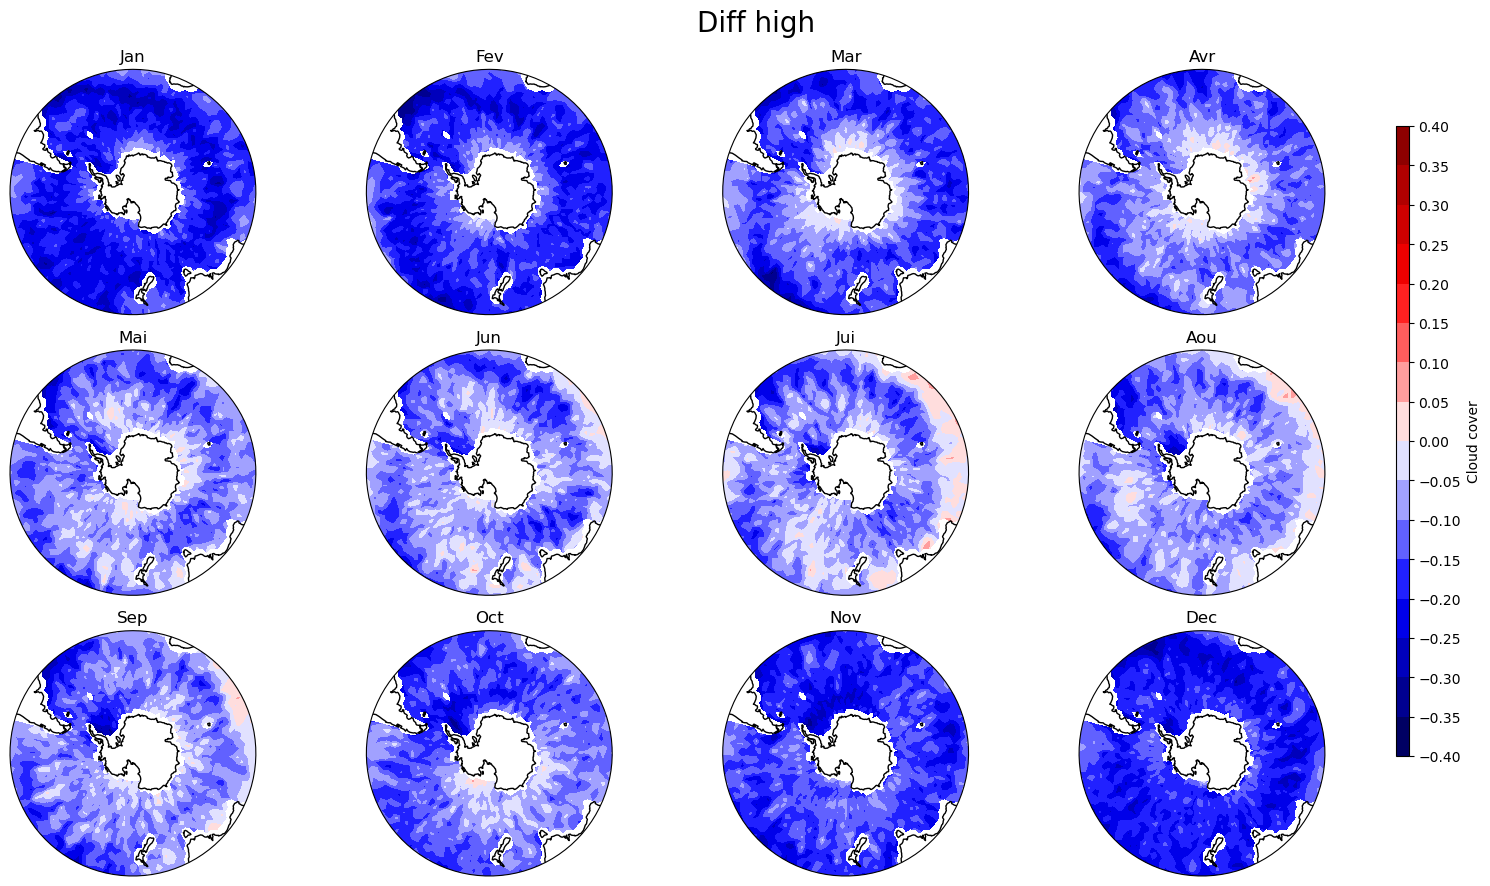

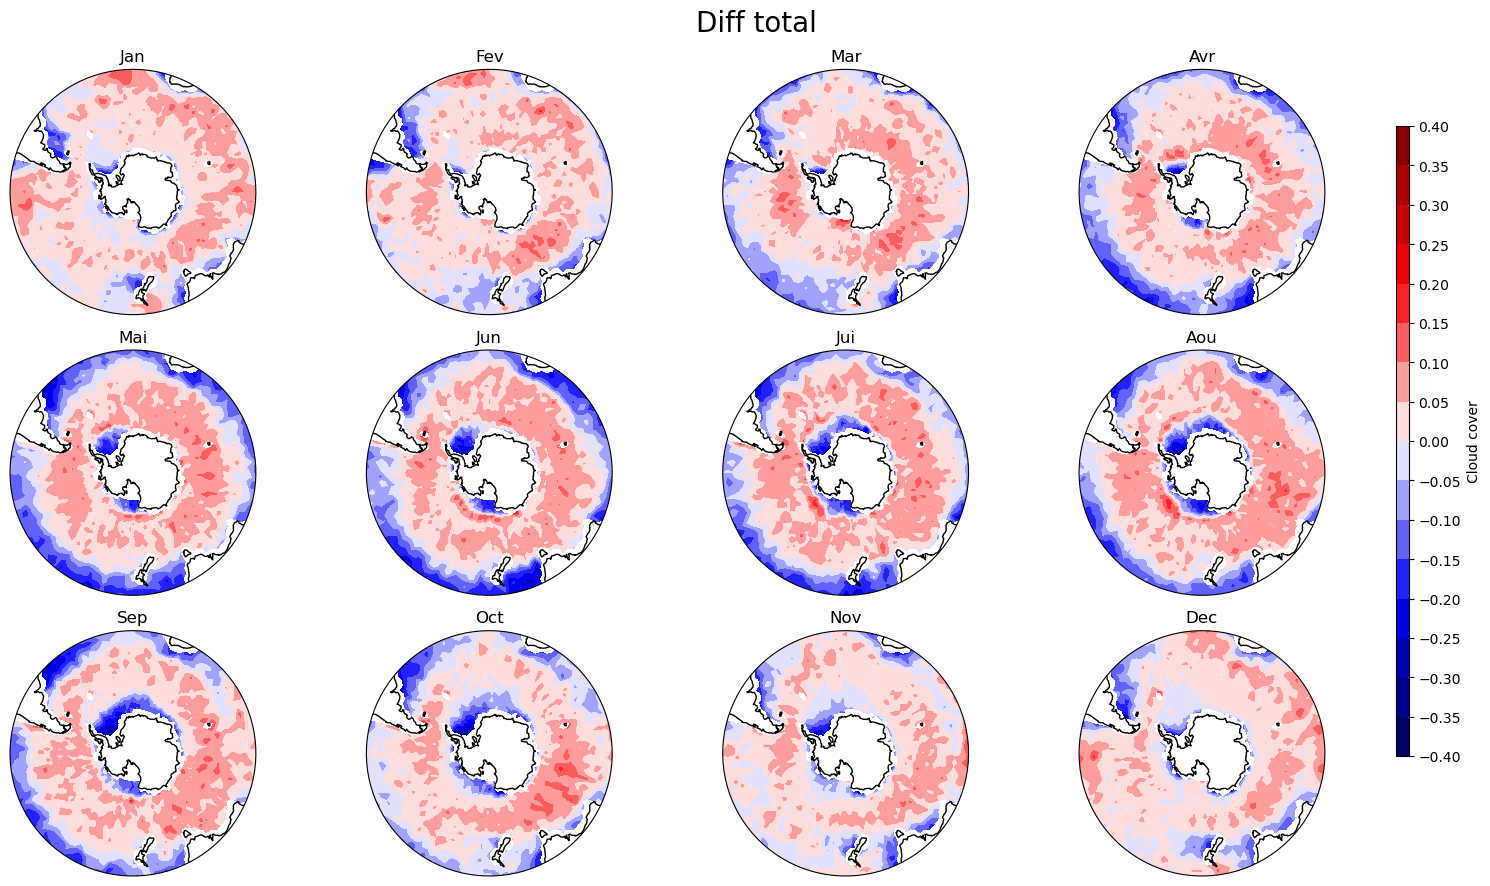

In [14]:
clevs = np.array([-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
cmap = 'seismic'
norm = None
plot_monthly_maps(clldiff, clevs, cmap, norm, title='Diff low', save='cll_monthly_austral_diff.png')
clevs = np.array([-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
plot_monthly_maps(clmdiff, clevs, cmap, norm, title='Diff mid', save='clm_monthly_austral_diff.png')
clevs = np.array([-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
plot_monthly_maps(clhdiff, clevs, cmap, norm, title='Diff high', save='clh_monthly_austral_diff.png')
plot_monthly_maps(cltdiff, clevs, cmap, norm, title='Diff total', save='clt_monthly_austral_diff.png')

In [15]:
# CALIPSO-GOCCP
cllobs_DJF = np.mean(cllobs[:,:,[0,1,11]], axis=2)
cllobs_MAM = np.mean(cllobs[:,:,[2,3,4]], axis=2)
cllobs_JJA = np.mean(cllobs[:,:,[5,6,7]], axis=2)
cllobs_SON = np.mean(cllobs[:,:,[9,9,10]], axis=2)
cllobs = np.ma.dstack((cllobs_DJF, cllobs_MAM, cllobs_JJA, cllobs_SON))

clmobs_DJF = np.mean(clmobs[:,:,[0,1,11]], axis=2)
clmobs_MAM = np.mean(clmobs[:,:,[2,3,4]], axis=2)
clmobs_JJA = np.mean(clmobs[:,:,[5,6,7]], axis=2)
clmobs_SON = np.mean(clmobs[:,:,[9,9,10]], axis=2)
clmobs = np.ma.dstack((clmobs_DJF, clmobs_MAM, clmobs_JJA, clmobs_SON))

clhobs_DJF = np.mean(clhobs[:,:,[0,1,11]], axis=2)
clhobs_MAM = np.mean(clhobs[:,:,[2,3,4]], axis=2)
clhobs_JJA = np.mean(clhobs[:,:,[5,6,7]], axis=2)
clhobs_SON = np.mean(clhobs[:,:,[9,9,10]], axis=2)
clhobs = np.ma.dstack((clhobs_DJF, clhobs_MAM, clhobs_JJA, clhobs_SON))

cltobs_DJF = np.mean(cltobs[:,:,[0,1,11]], axis=2)
cltobs_MAM = np.mean(cltobs[:,:,[2,3,4]], axis=2)
cltobs_JJA = np.mean(cltobs[:,:,[5,6,7]], axis=2)
cltobs_SON = np.mean(cltobs[:,:,[9,9,10]], axis=2)
cltobs = np.ma.dstack((cltobs_DJF, cltobs_MAM, cltobs_JJA, cltobs_SON))

# LMDZ6A
clllmdz6a_DJF = np.mean(clllmdz6a[:,:,[0,1,11]], axis=2)
clllmdz6a_MAM = np.mean(clllmdz6a[:,:,[2,3,4]], axis=2)
clllmdz6a_JJA = np.mean(clllmdz6a[:,:,[5,6,7]], axis=2)
clllmdz6a_SON = np.mean(clllmdz6a[:,:,[8,9,10]], axis=2)
clllmdz6a = np.ma.dstack((clllmdz6a_DJF, clllmdz6a_MAM, clllmdz6a_JJA, clllmdz6a_SON))

clmlmdz6a_DJF = np.mean(clmlmdz6a[:,:,[0,1,11]], axis=2)
clmlmdz6a_MAM = np.mean(clmlmdz6a[:,:,[2,3,4]], axis=2)
clmlmdz6a_JJA = np.mean(clmlmdz6a[:,:,[5,6,7]], axis=2)
clmlmdz6a_SON = np.mean(clmlmdz6a[:,:,[8,9,10]], axis=2)
clmlmdz6a = np.ma.dstack((clmlmdz6a_DJF, clmlmdz6a_MAM, clmlmdz6a_JJA, clmlmdz6a_SON))

clhlmdz6a_DJF = np.mean(clhlmdz6a[:,:,[0,1,11]], axis=2)
clhlmdz6a_MAM = np.mean(clhlmdz6a[:,:,[2,3,4]], axis=2)
clhlmdz6a_JJA = np.mean(clhlmdz6a[:,:,[5,6,7]], axis=2)
clhlmdz6a_SON = np.mean(clhlmdz6a[:,:,[8,9,10]], axis=2)
clhlmdz6a = np.ma.dstack((clhlmdz6a_DJF, clhlmdz6a_MAM, clhlmdz6a_JJA, clhlmdz6a_SON))

cltlmdz6a_DJF = np.mean(cltlmdz6a[:,:,[0,1,11]], axis=2)
cltlmdz6a_MAM = np.mean(cltlmdz6a[:,:,[2,3,4]], axis=2)
cltlmdz6a_JJA = np.mean(cltlmdz6a[:,:,[5,6,7]], axis=2)
cltlmdz6a_SON = np.mean(cltlmdz6a[:,:,[8,9,10]], axis=2)
cltlmdz6a = np.ma.dstack((cltlmdz6a_DJF, cltlmdz6a_MAM, cltlmdz6a_JJA, cltlmdz6a_SON))

# DIFFERENCE
clldiff_DJF = np.mean(clldiff[:,:,[0,1,11]], axis=2)
clldiff_MAM = np.mean(clldiff[:,:,[2,3,4]], axis=2)
clldiff_JJA = np.mean(clldiff[:,:,[5,6,7]], axis=2)
clldiff_SON = np.mean(clldiff[:,:,[8,9,10]], axis=2)
clldiff = np.ma.dstack((clldiff_DJF, clldiff_MAM, clldiff_JJA, clldiff_SON))

clmdiff_DJF = np.mean(clmdiff[:,:,[0,1,11]], axis=2)
clmdiff_MAM = np.mean(clmdiff[:,:,[2,3,4]], axis=2)
clmdiff_JJA = np.mean(clmdiff[:,:,[5,6,7]], axis=2)
clmdiff_SON = np.mean(clmdiff[:,:,[8,9,10]], axis=2)
clmdiff = np.ma.dstack((clmdiff_DJF, clmdiff_MAM, clmdiff_JJA, clmdiff_SON))

clhdiff_DJF = np.mean(clhdiff[:,:,[0,1,11]], axis=2)
clhdiff_MAM = np.mean(clhdiff[:,:,[2,3,4]], axis=2)
clhdiff_JJA = np.mean(clhdiff[:,:,[5,6,7]], axis=2)
clhdiff_SON = np.mean(clhdiff[:,:,[8,9,10]], axis=2)
clhdiff = np.ma.dstack((clhdiff_DJF, clhdiff_MAM, clhdiff_JJA, clhdiff_SON))

cltdiff_DJF = np.mean(cltdiff[:,:,[0,1,11]], axis=2)
cltdiff_MAM = np.mean(cltdiff[:,:,[2,3,4]], axis=2)
cltdiff_JJA = np.mean(cltdiff[:,:,[5,6,7]], axis=2)
cltdiff_SON = np.mean(cltdiff[:,:,[8,9,10]], axis=2)
cltdiff = np.ma.dstack((cltdiff_DJF, cltdiff_MAM, cltdiff_JJA, cltdiff_SON))

### SEASONAL MAPS

In [16]:
# FUNCTION
def plot_seasonal_maps(var, clevs, cmap, norm, title, save) :
    fig, axes = plt.subplots(figsize=(16,9), nrows=2, ncols=2, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
    
    title_list = ['DJF summer', 'MAM fall', 'JJA winter', 'SON spring']
    pltcounter = 0
    for plotid in axes.flat:
        
        pltcounter = pltcounter + 1
        
        clplot = var[:,:,pltcounter-1]
        
        clplt, lonplt = add_cyclic_point(clplot, coord=lon) # filling the gap at longitude 0
    
        plotid.set_extent([-180, 180, np.min(lat), np.max(lat)], ccrs.PlateCarree())
        plotid.set_boundary(map_circle, transform=plotid.transAxes)
        
        cs = plotid.contourf(lonplt, lat, clplt, clevs, transform=ccrs.PlateCarree(),  
                             norm = norm, 
                             cmap=cmap)
        
        plotid.coastlines(resolution="110m",linewidth=1)
        plotid.set_title(title_list[pltcounter-1])
        
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.008, 0.7])
    fig.colorbar(cs, cax=cbar_ax, ticks=clevs, label='Cloud cover')
    path_fig = '/home/jcharrel/Documents/M2_Internship_LMD/figures/2DCloudCover/maps/seasonal/'
    plt.savefig(path_fig+save,dpi=300)

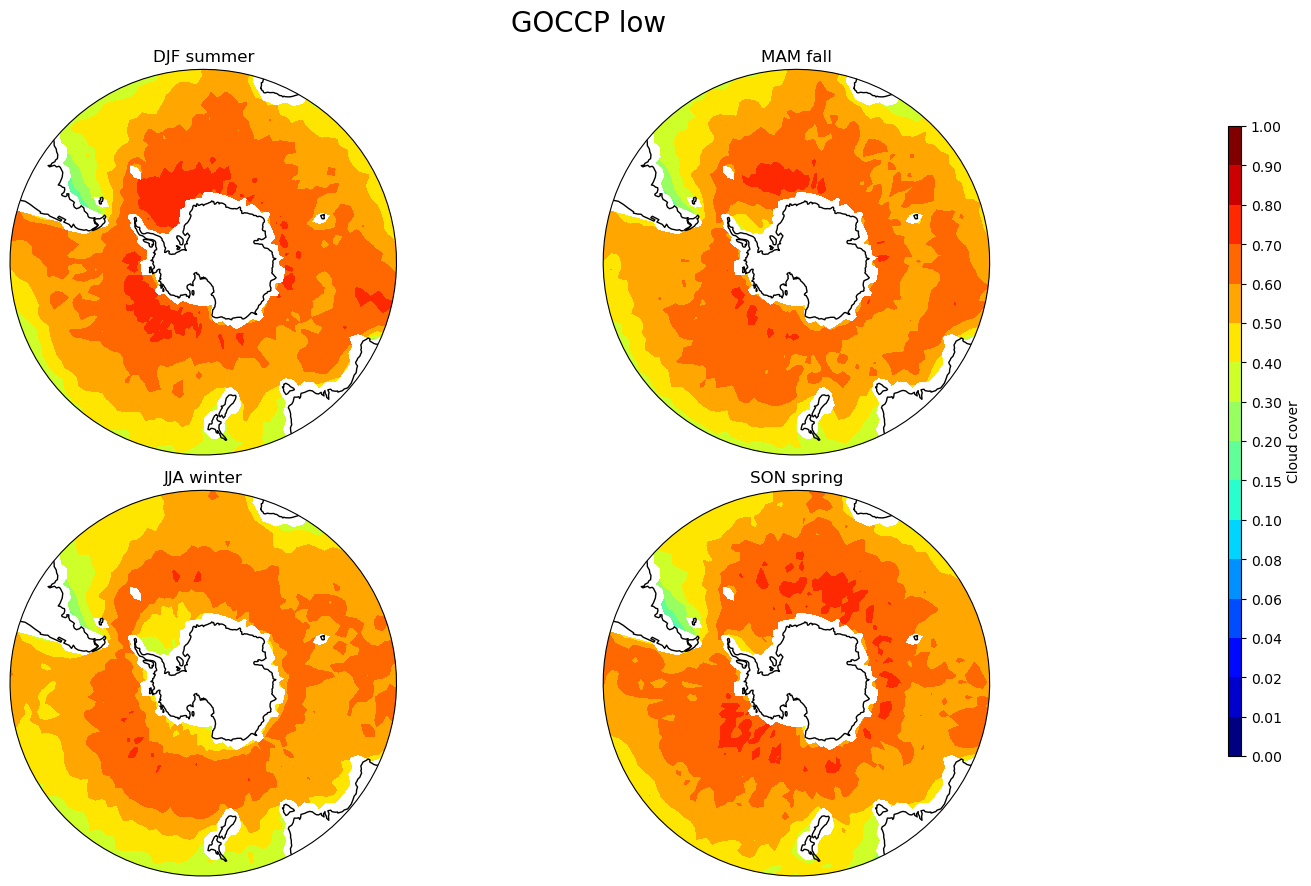

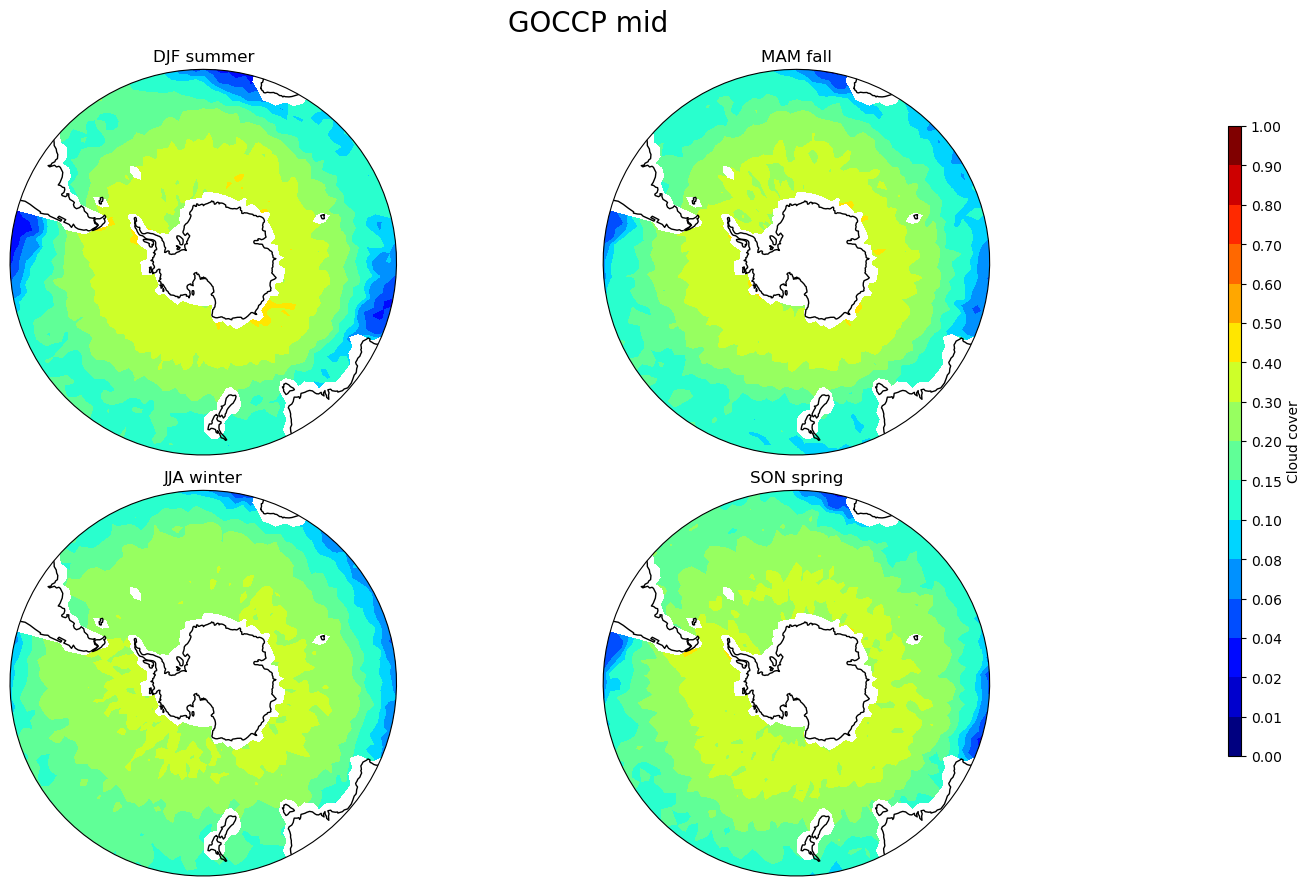

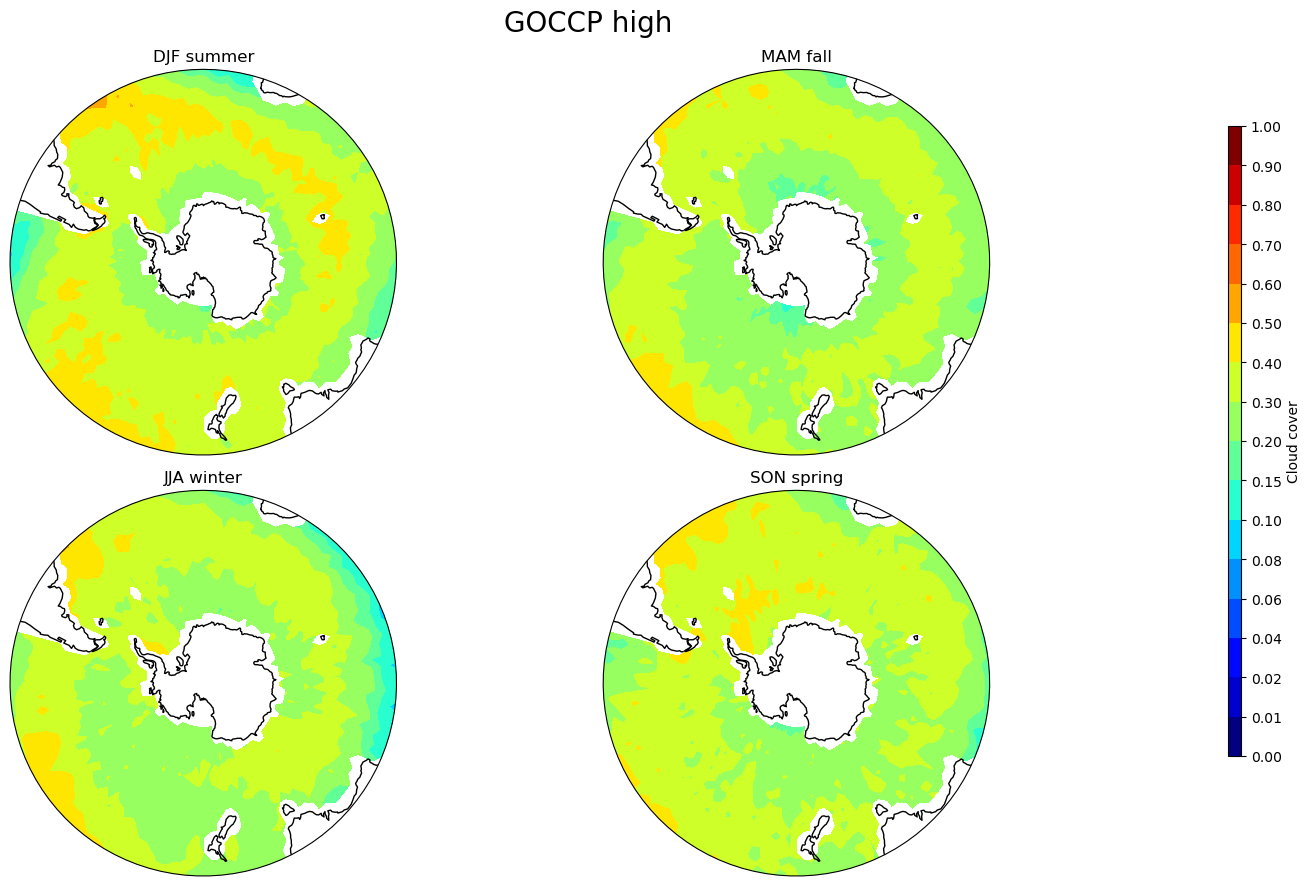

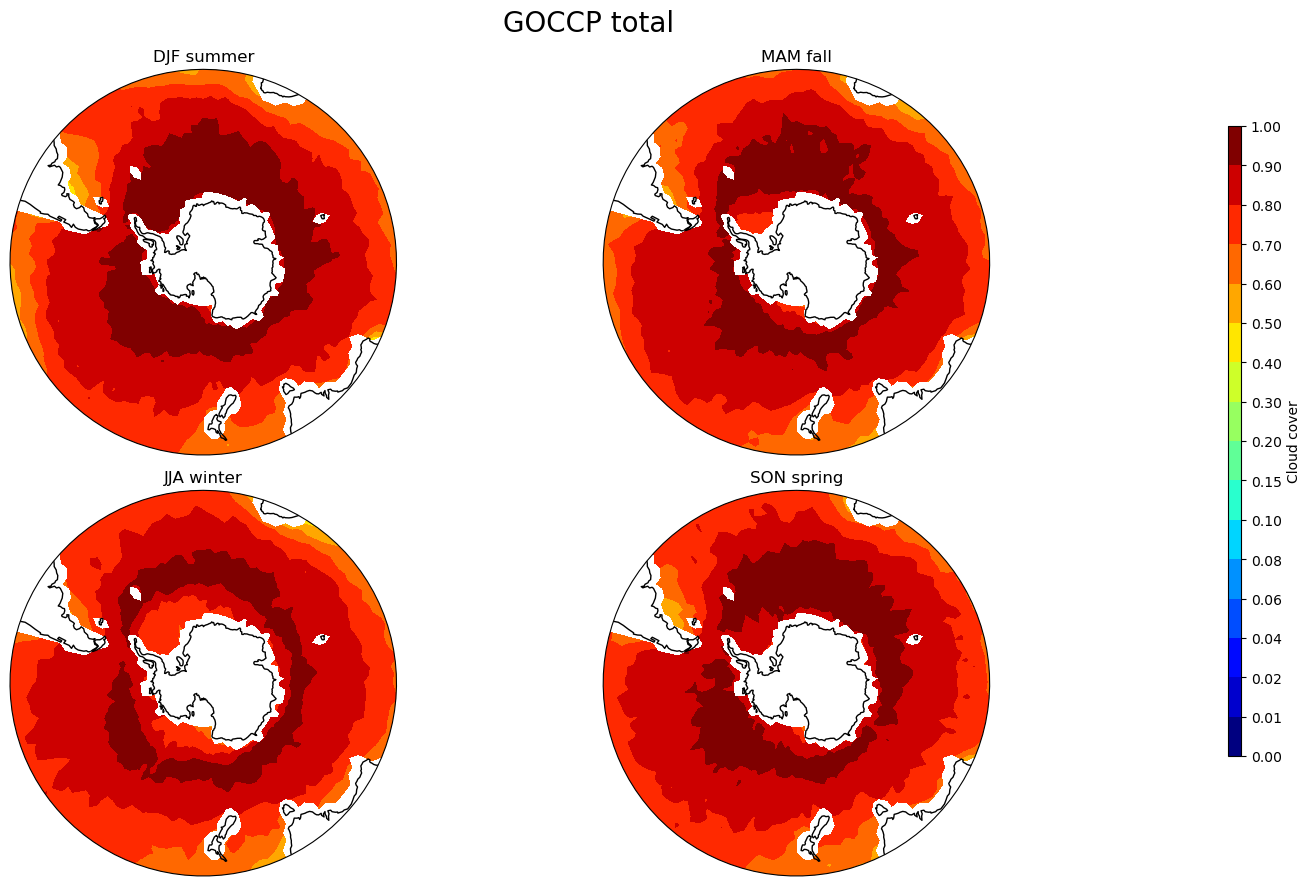

In [17]:
clevs = np.array([0,1,2,4,6,8,10,15,20,30,40,50,60,70,80,90,100])*1e-2
cmap = 'jet'
norm = mpl.colors.BoundaryNorm(boundaries=clevs, ncolors=256)
plot_seasonal_maps(cllobs, clevs, cmap, norm, title='GOCCP low', save='cll_seasonal_austral_obs.png')
plot_seasonal_maps(clmobs, clevs, cmap, norm, title='GOCCP mid', save='clm_seasonal_austral_obs.png')
plot_seasonal_maps(clhobs, clevs, cmap, norm, title='GOCCP high', save='clh_seasonal_austral_obs.png')
plot_seasonal_maps(cltobs, clevs, cmap, norm, title='GOCCP total', save='clt_seasonal_austral_obs.png')

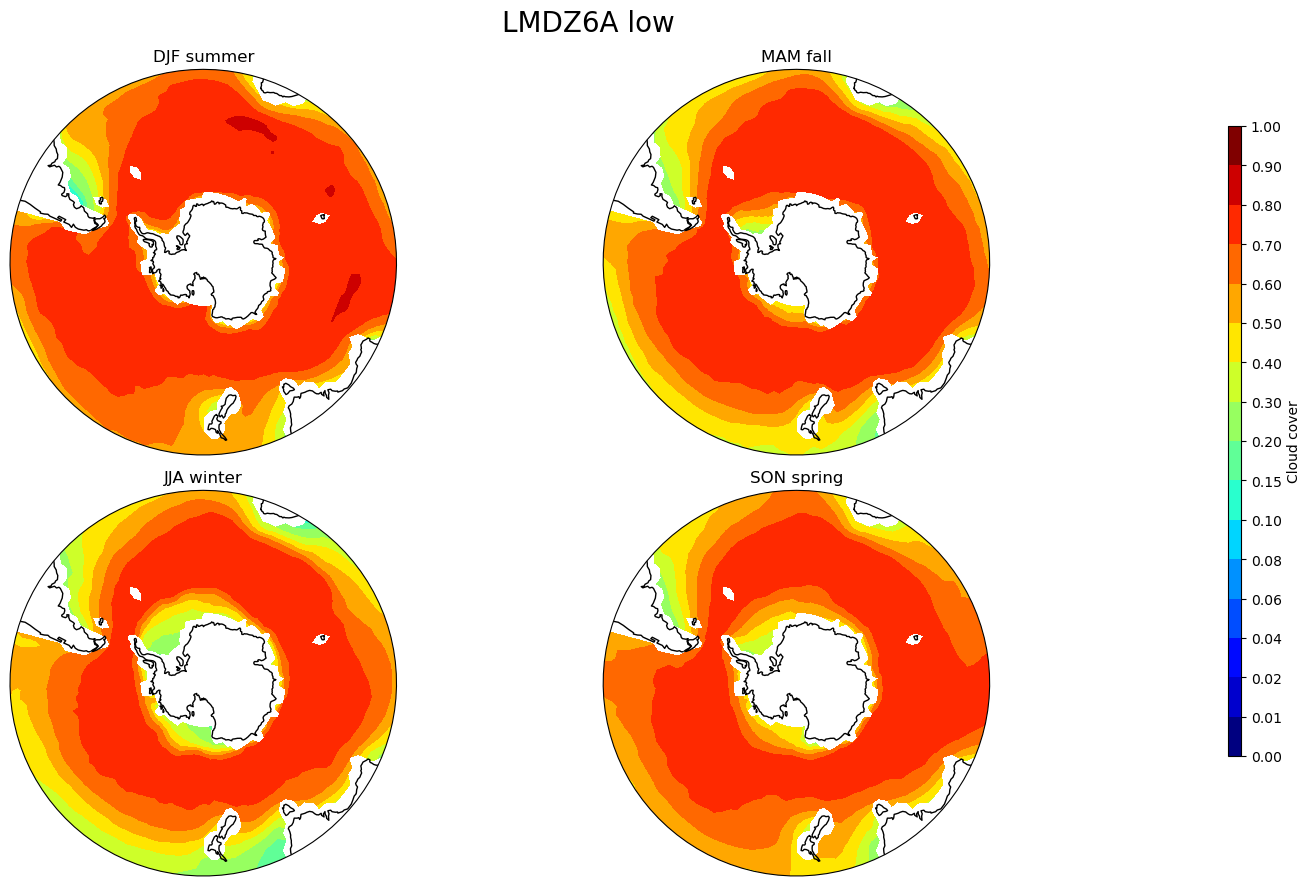

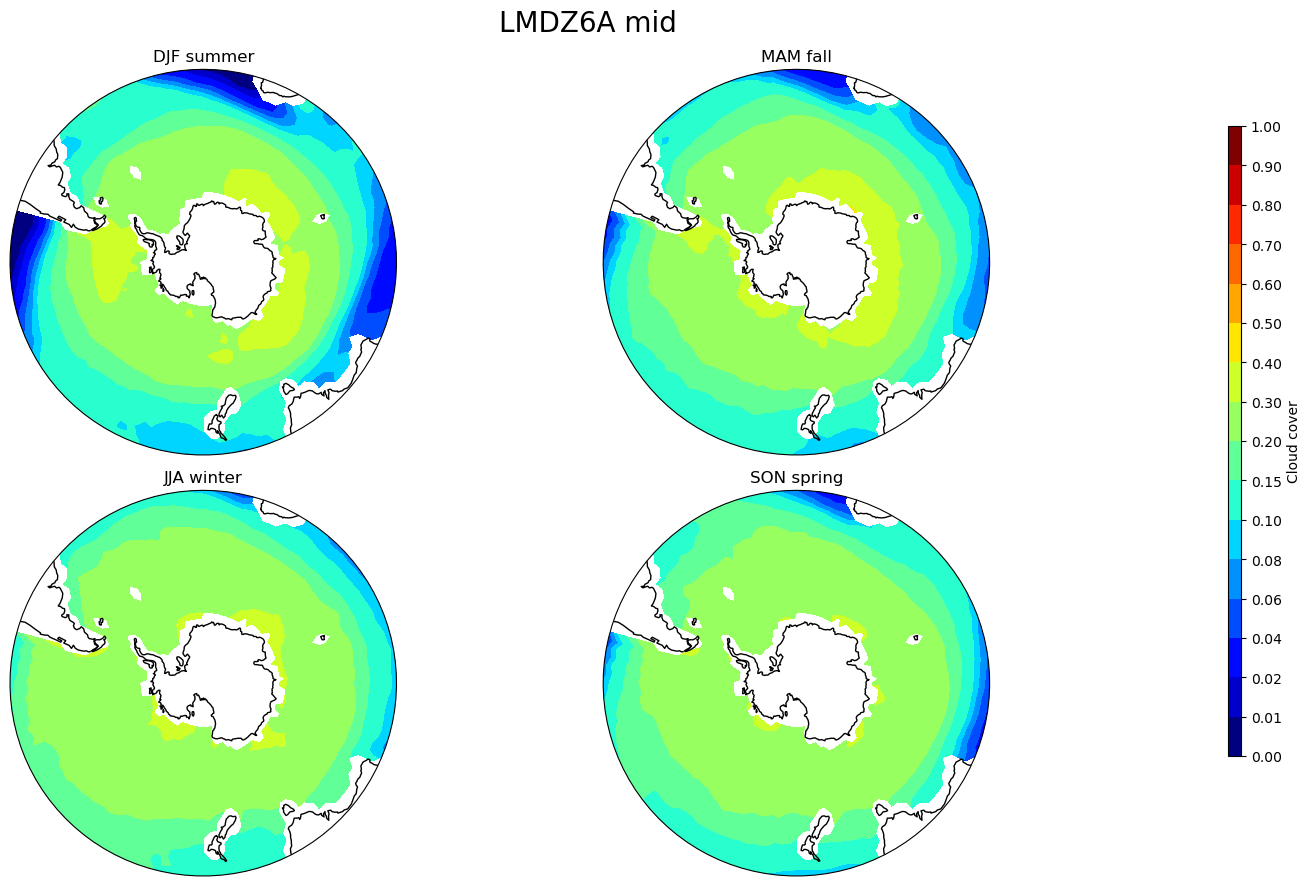

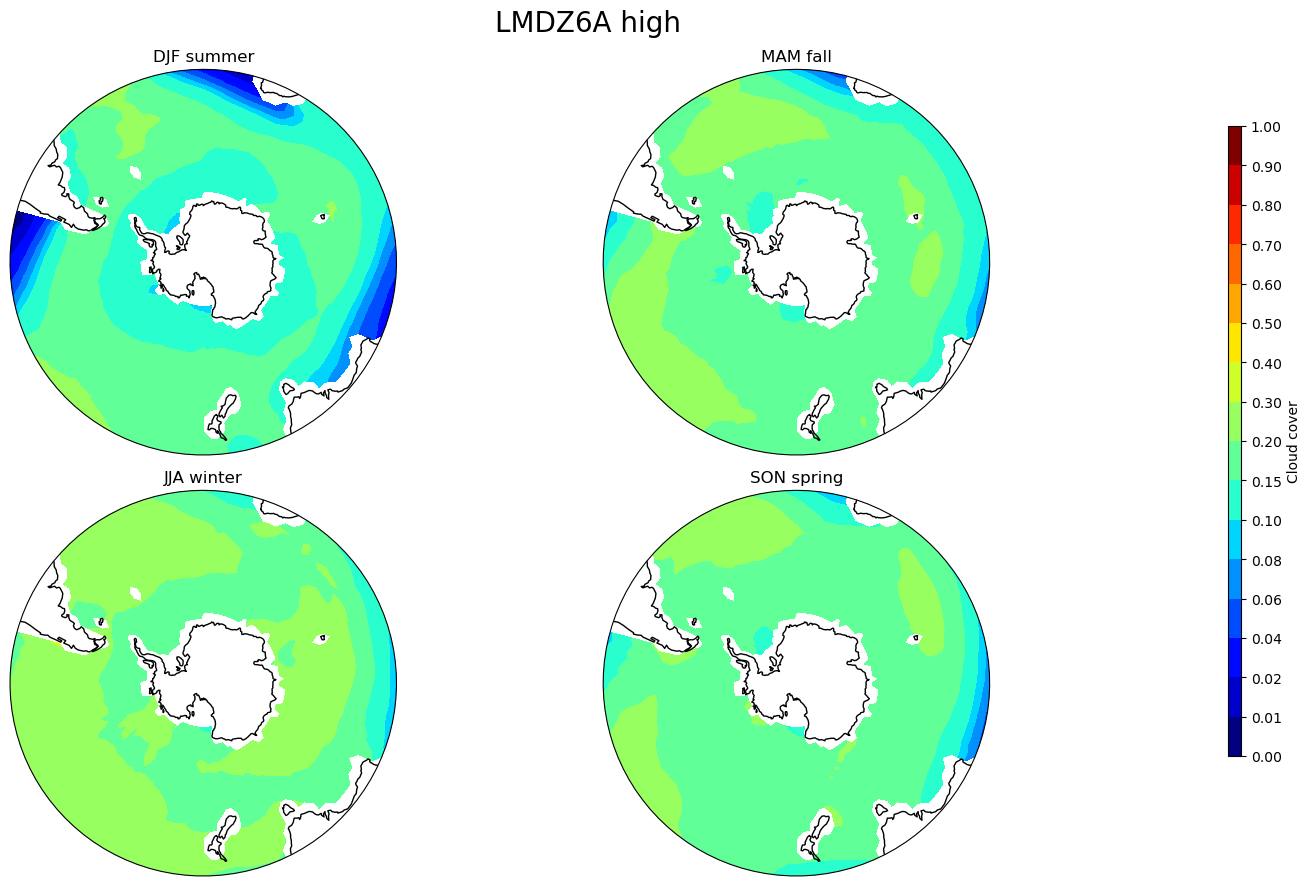

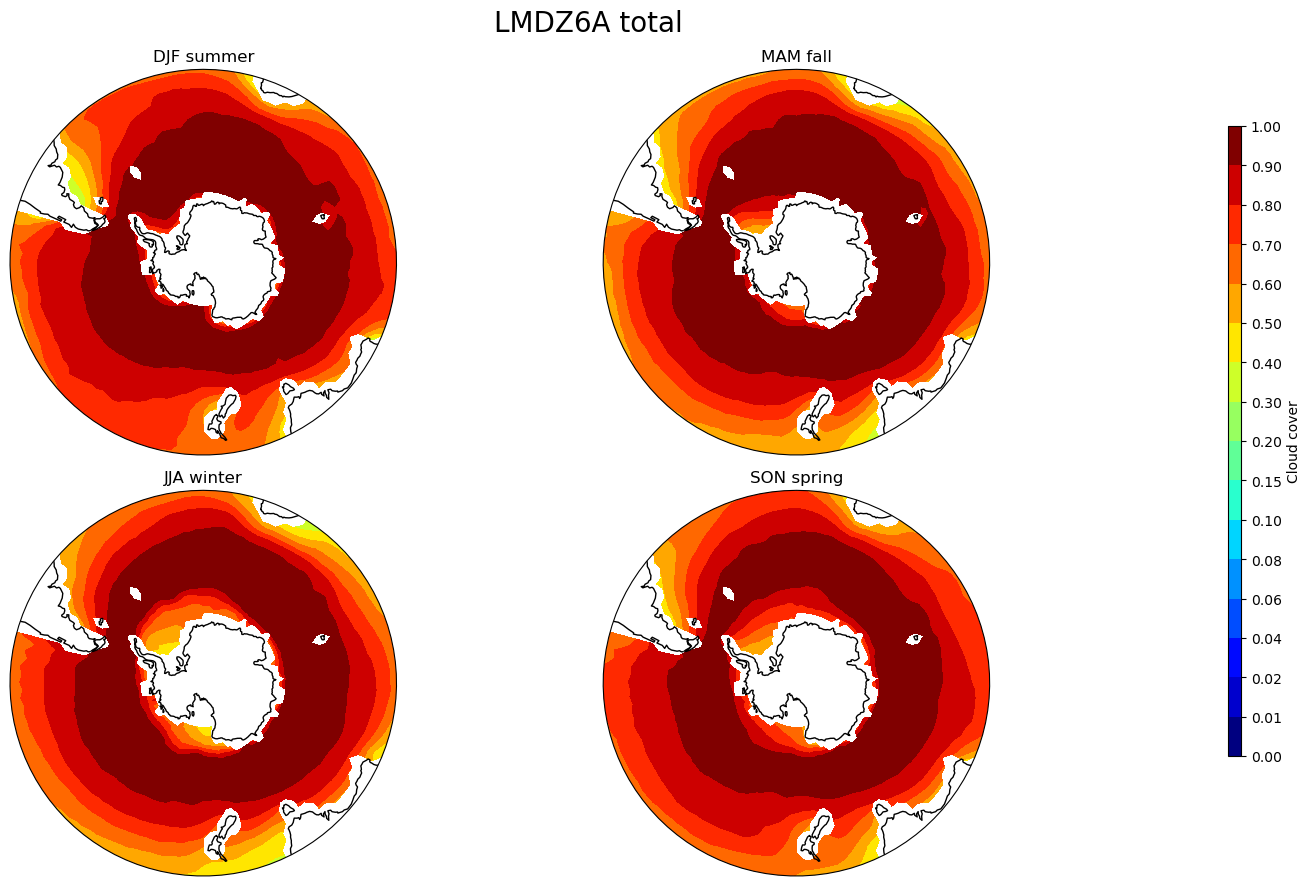

In [18]:
plot_seasonal_maps(clllmdz6a, clevs, cmap, norm, title='LMDZ6A low', save='cll_seasonal_austral_lmdz6a.png')
plot_seasonal_maps(clmlmdz6a, clevs, cmap, norm, title='LMDZ6A mid', save='clm_seasonal_austral_lmdz6a.png')
plot_seasonal_maps(clhlmdz6a, clevs, cmap, norm, title='LMDZ6A high', save='clh_seasonal_austral_lmdz6a.png')
plot_seasonal_maps(cltlmdz6a, clevs, cmap, norm, title='LMDZ6A total', save='clt_seasonal_austral_lmdz6a.png')

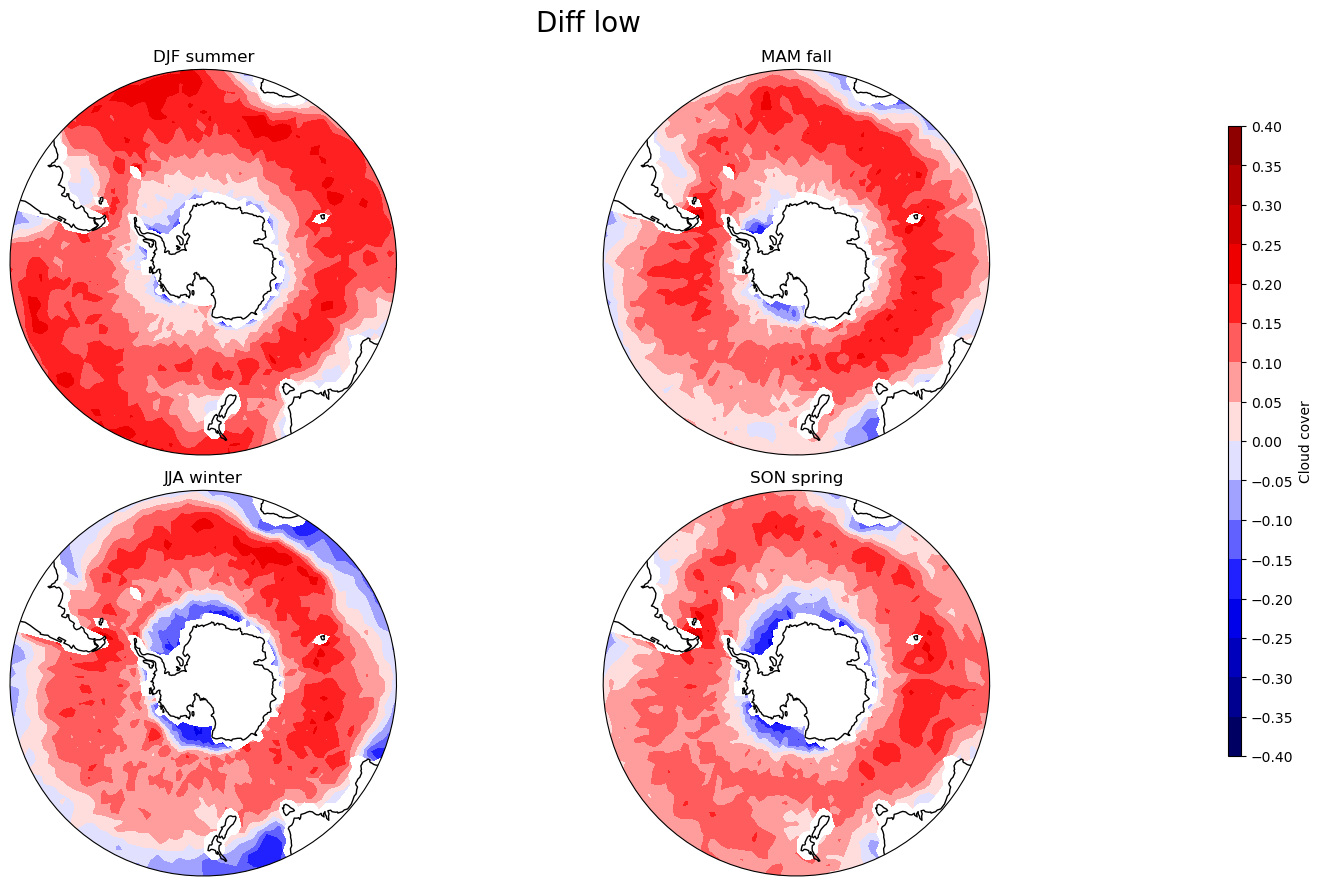

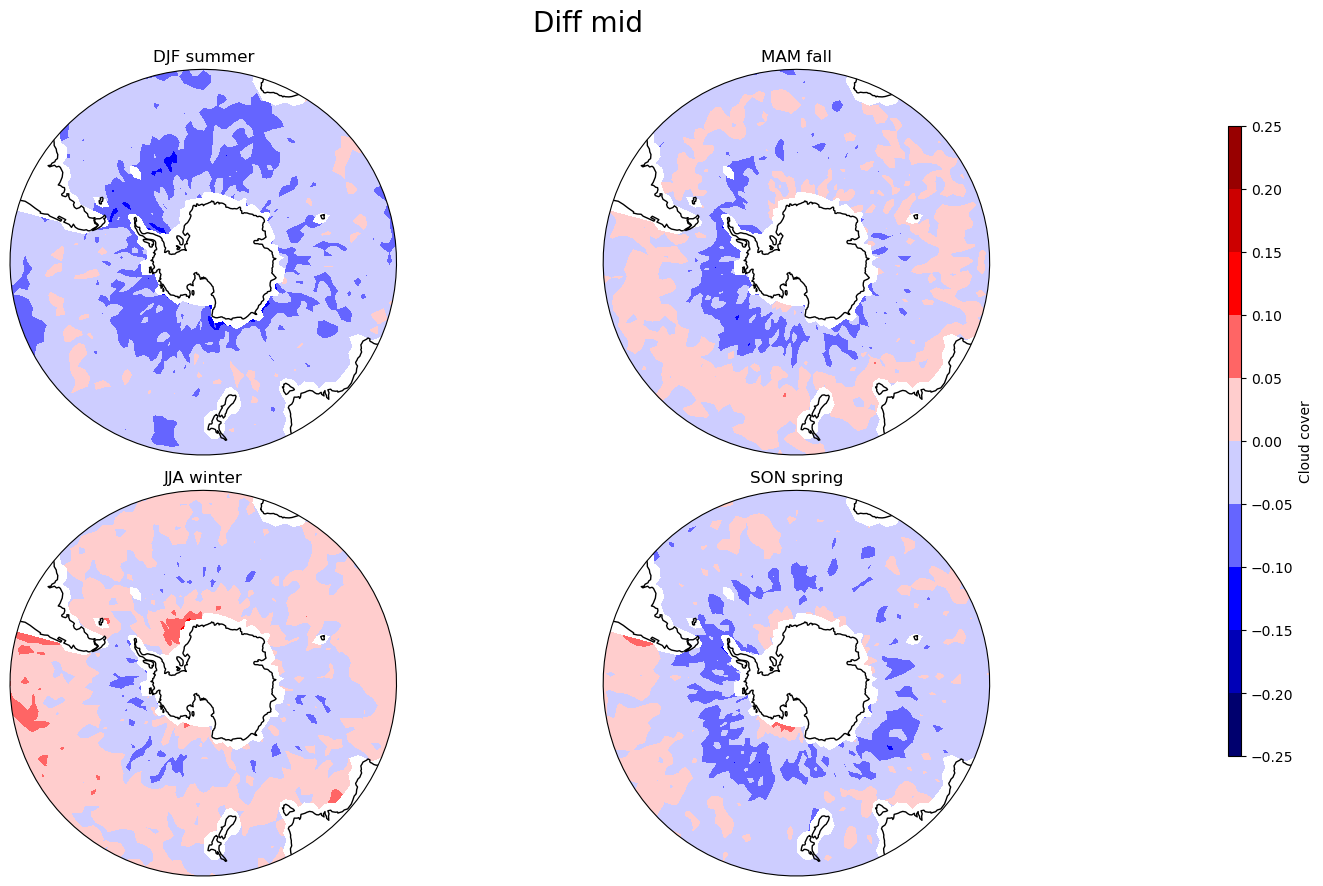

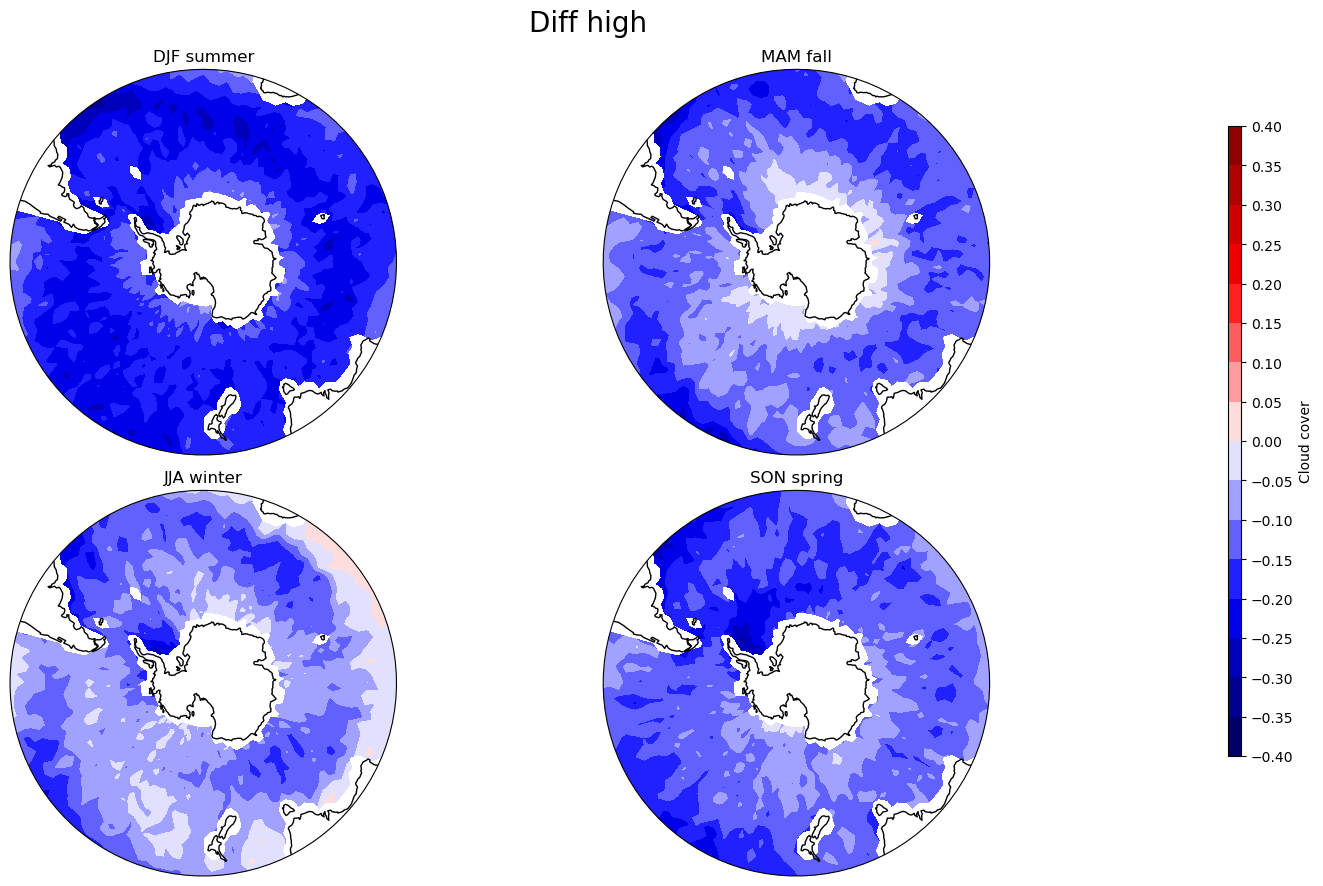

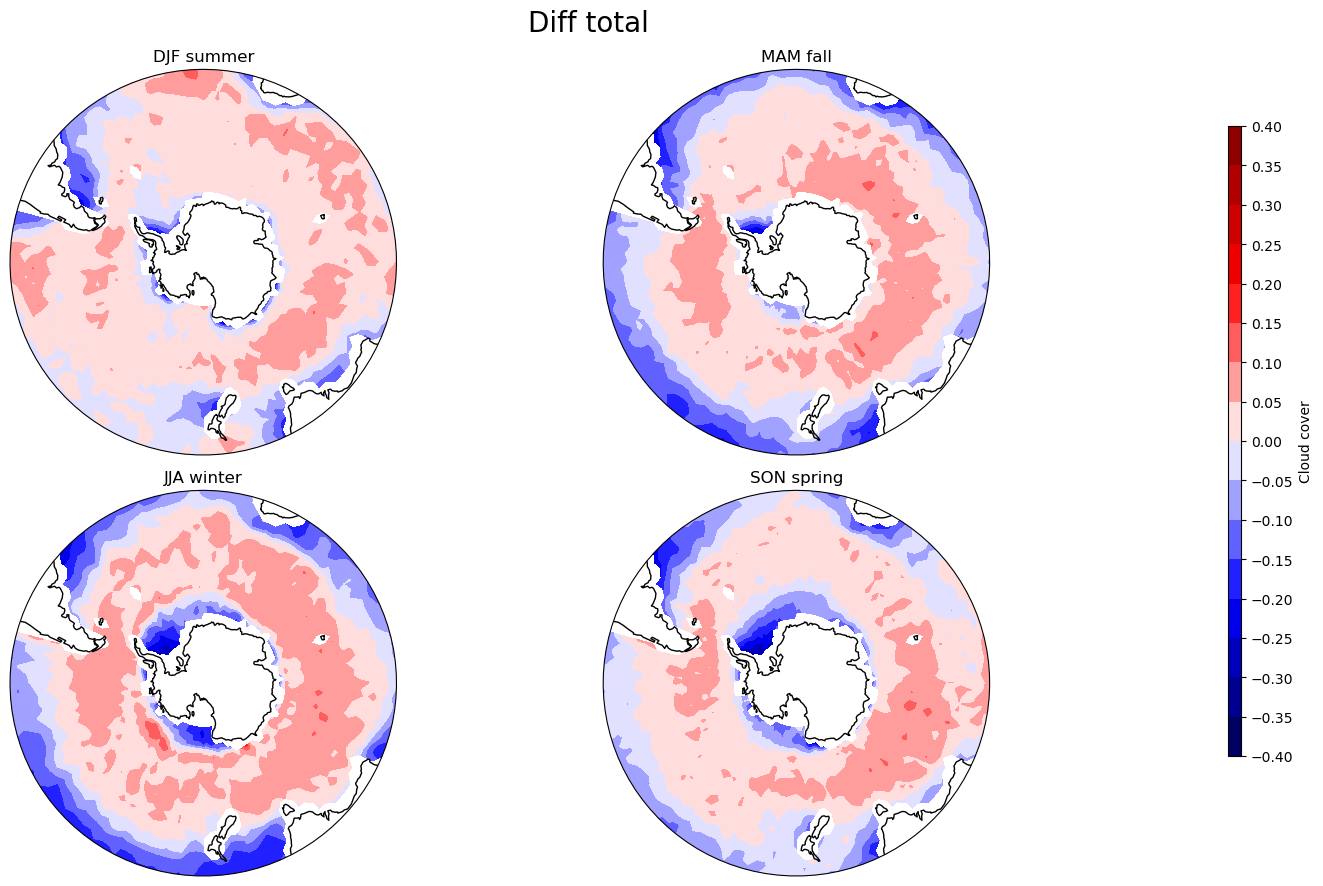

In [19]:
clevs = np.array([-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
cmap = 'seismic'
norm = None
plot_seasonal_maps(clldiff, clevs, cmap, norm, title='Diff low', save='cll_seasonal_austral_diff.png')
clevs = np.array([-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
plot_seasonal_maps(clmdiff, clevs, cmap, norm, title='Diff mid', save='clm_seasonal_austral_diff.png')
clevs = np.array([-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
plot_seasonal_maps(clhdiff, clevs, cmap, norm, title='Diff high', save='clh_seasonal_austral_diff.png')
plot_seasonal_maps(cltdiff, clevs, cmap, norm, title='Diff total', save='clt_seasonal_austral_diff.png')